In [ ]:
pip install 'import_ipynb'

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=0227b3d20a89fc4085e7665385c7e03faea80de66be601b9fc02feea07b9f6b1
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
  
%cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
 
 
import import_ipynb
from cifar100 import cifar_100
from net import resnet32

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
importing Jupyter notebook from cifar100.ipynb
IMPORT CIFAR DONE Rseed
importing Jupyter notebook from net.ipynb
IMPORT NET DONE


iCarl Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
from net import resnet32
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import seaborn as sn
import matplotlib.patches as mpatches


class iCaRLNet(nn.Module):
    def __init__(self, feature_size, n_classes, lr=2.0, gamma=0.2, weight_decay=1e-5, milestone=[49, 63], batch_size=128, num_epochs=70, momentum=0.9):
        # Network architecture
        super(iCaRLNet, self).__init__()
        self.net = resnet32(num_classes=n_classes)
        self.feature_extractor = self.net.get_fm_out
        self.lr = lr
        self.gamma = gamma
        self.weight_decay = weight_decay
        self.milestone = milestone
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.n_classes = 0
        self.n_known = 0
        self.momentum = momentum

        # List containing exemplar_sets
        # Each exemplar_set is a np.array of N images
        # with shape (N, C, H, W)
        self.exemplar_sets = []

        # Learning method
        self.BCEwithL = nn.BCEWithLogitsLoss()
        self.cls_loss = nn.CrossEntropyLoss()

        # Means of exemplars
        self.compute_means = True
        self.exemplar_means = []


    def forward(self, x):
      self.net = self.net.cuda()
      return self.net.forward(x)


    def increment_classes(self, n):
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features + n, bias=False)
        self.fc.weight.data[:out_features] = weight
        self.n_classes += n

    def classify(self, x, cif):      
       

        if self.compute_means:
            print("Computing mean of exemplars...")
            exemplar_means = []
            for P_y in self.exemplar_sets:  #P_y list of indices
                features = np.zeros((0,64))
                sub = Subset(cif, P_y)
                dl = torch.utils.data.DataLoader(sub, batch_size=self.batch_size,
                                               shuffle=False, num_workers=4)
                # Extract feature for each exemplar in P_y
                with torch.no_grad():
                  for ind, ex, lab in dl:
                    ex = Variable(ex).cuda()
                    feature = self.feature_extractor(ex).data.cpu().numpy()
                    feature = normalize(feature, axis=1, norm='l2')
                    features = np.concatenate((features,feature), axis=0)

                features = torch.tensor(features)
                mu_y = features.mean(0).squeeze()
                mu_y.data = mu_y.data / torch.norm(mu_y, p=2)  # L2 Normalize
                exemplar_means.append(mu_y)

            self.exemplar_means = exemplar_means
            self.compute_means = False
            print("Done")


        exemplar_means = self.exemplar_means
        means = torch.stack(exemplar_means)  # (n_classes, feature_size)
        means = torch.stack([means] * self.batch_size)  # (batch_size, n_classes, feature_size)
        means = means.transpose(1, 2)  # (batch_size, feature_size, n_classes)

        feature = self.feature_extractor(x)  # (batch_size, feature_size)
        for i in range(feature.size(0)):  # Normalize
            feature.data[i] = feature.data[i] / torch.norm(feature.data[i], p=2)
        feature = feature.unsqueeze(2)  # (batch_size, feature_size, 1)
        feature = feature.expand_as(means)  # (batch_size, feature_size, n_classes)
        feature = feature.cuda()
        means = means.cuda()
        dists = torch.sqrt((feature - means).pow(2).sum(1)).squeeze()  # (batch_size, n_classes)
        _, preds = dists.min(1) 
        return preds

    def construct_exemplar_set(self, images, m):
        # Compute and cache features for each example
        features = np.zeros((0,64))
        indices = np.zeros((0), dtype=int)
        dl = torch.utils.data.DataLoader(images, batch_size=self.batch_size,
                                               shuffle=False, num_workers=4)
        with torch.no_grad():
          for ind, img, lab in dl:
            x = Variable(img).cuda()
            feature = self.feature_extractor(x).data.cpu().numpy()
            feature = normalize(feature, axis=1, norm='l2')
            features = np.concatenate((features,feature), axis=0)
            indices = np.concatenate((indices,ind), axis=0)

        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

        exemplar_set = []
        exemplar_features = np.zeros((0,64))

        for k in range(1, int(m)+1):
            S = np.sum(exemplar_features, axis=0)
            phi = features
            mu = class_mean
            mu_p = 1.0 / k * (phi + S)
            mu_p = normalize(mu_p, axis=1, norm='l2')
            i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
            exemplar_set.append(indices[i])
            addfeature =  np.expand_dims(features[i], axis=0)
            exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

            #remove duplicates
            features = np.delete(features, i, 0)
            indices = np.delete(indices, i, 0)
        self.exemplar_sets.append(exemplar_set)
        


    def reduce_exemplar_sets(self, m):
        for y, P_y in enumerate(self.exemplar_sets):
            self.exemplar_sets[y] = P_y[:int(m)]

    def combine_dataset_with_exemplars(self, cifar):
        newindexes = []
        for y, P_y in enumerate(self.exemplar_sets):
            exemplar_images = P_y
            exemplar_labels = [y] * len(P_y)
            print(exemplar_images[0].shape)
            newindexes+=cifar.data_append(exemplar_images, exemplar_labels)
        return newindexes

    def exemplarIndexes(self):
      Indexes = []
      for P_y in self.exemplar_sets:
        Indexes += P_y
      return Indexes


    

    def update_representation(self, cifar, batchindexes, diz):
        prev_model = copy.deepcopy(self)
        prev_model = prev_model.eval().cuda()
        self.compute_means = True

        self.n_classes += 10
        print("%d new classes" % (10))
        print(len(batchindexes))
        # Form combined training set
        newindexes = []
        if self.n_classes > 10:
          newindexes = self.exemplarIndexes()
        newindexes += list(batchindexes)
        print(len(newindexes))
        reprdata = Subset(cifar, newindexes)

        loader = torch.utils.data.DataLoader(reprdata, batch_size=self.batch_size,
                                             shuffle=True, num_workers=4, drop_last=True)

        # Run network training

        optimizer = optim.SGD(self.net.parameters(), lr=self.lr, weight_decay=self.weight_decay, momentum=self.momentum)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestone, gamma=self.gamma)
        print("TRAIN")
        for epoch in range(self.num_epochs):
          losses = []
          for indices, images, labels in loader:
            labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
            images = Variable(torch.FloatTensor(images)).cuda()
            labels = Variable(labels).cuda()
            optimizer.zero_grad()
            g = self.forward(images)
            y_hot = F.one_hot(labels, self.n_classes).float().cuda()
            
            if self.n_known > 0:
              q = prev_model.forward(images)
              q = torch.sigmoid(q)
              target = torch.cat((q[:,:self.n_known], y_hot[:,self.n_known:self.n_classes]), dim=1)
              loss = self.BCEwithL(g[:,:self.n_classes], target)

              
            else:
              loss = self.BCEwithL(g[:,:self.n_classes], y_hot[:,:self.n_classes])
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

          if (epoch + 1) % 5 == 0:
            print('Epoch [%d/%d], Average_Loss: %.4f' \
                  % (epoch + 1, self.num_epochs, np.mean(np.array(losses))))
            
          scheduler.step()


    def exemplarsTSNE(self, cif, classList, m, inc = False):
      self.eval()
      exemplars = []
      diz = cif.get_dictionary()
      if inc == False:
        selfExemplars = self.exemplar_sets
        n_tags        = self.n_classes
        y_pal_offset  = 0
      else:
        selfExemplars = self.exemplar_sets[self.n_classes-10:self.n_classes]
        n_tags        = 10
        y_pal_offset  = 10 - self.n_classes

      for P_y in selfExemplars:
        for y in P_y:
          exemplars.append(y)
      
      sub = Subset(cif, exemplars)
      dl = torch.utils.data.DataLoader(sub, batch_size=self.batch_size, shuffle=False, num_workers=4)
      dataX   = np.zeros((0,64))
      labelsY = torch.tensor([], dtype=torch.int64)

      for _, images, labels in dl:
        # print(dataX.size())
        # print(labelsY.size())
        labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
        images = images.cuda()
        feature = self.feature_extractor(images).data.cpu().numpy()
        feature = normalize(feature, axis=1, norm='l2')
        dataX   = np.concatenate((dataX, feature), axis=0)
        labelsY = torch.cat((labelsY, labels), dim = 0)

      print("dataX shape and labelsY size...")
      print(dataX.shape)
      print(labelsY.size())
      print("Creating tSNE Model...")
      labelsY = labelsY.numpy()
      dataX_embedded = TSNE(n_components=2, perplexity=float(m), n_iter=5000).fit_transform(dataX)
      print(dataX_embedded.shape)   

      palette = sn.hls_palette(n_tags, l=.4, s=1.)

      lepalette = []
      for y in labelsY:
        c = palette[y + y_pal_offset]
        lepalette.append(c)
      
      
      plt.figure(figsize=(30, 24))
      plt.scatter(dataX_embedded[:, 0], dataX_embedded[:, 1], c = lepalette)
      # plt.yticks([-130, -100, -75, -50, -25, 0 , 25, 50, 75, 100, 130])
      # plt.xticks([-130, -100, -75, -50, -25, 0 , 25, 50, 75, 100, 130])
      # plt.yticks([-100, -75, -50, -25, 0 , 25, 50, 75, 100])
      # plt.xticks([-100, -75, -50, -25, 0 , 25, 50, 75, 100])       
      
      if inc == False:
        %cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/all/perplexityM
        params = {'font.size': 22,
          'legend.fontsize': 8,
          'legend.handlelength': 2}
        plt.rcParams.update(params)
        patches = []
        for c in range(0, self.n_classes):
          patch = mpatches.Patch(color=palette[c], label=f'class_{classList[c]}')
          patches.append(patch)
        plt.title(f'allExemplars_t-SNE_nclass({self.n_classes})_nEpochs({self.num_epochs})_perplexity({m}).png')
        plt.savefig(f'allExemplars_t-SNE_nclass({self.n_classes})_nEpochs({self.num_epochs})_legend(no).png')
        # %cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/all/perplexityM
        # plt.legend(handles=patches)
        # plt.savefig(f'allExemplars_t-SNE_nclass({self.n_classes})_nEpochs({self.num_epochs})_legend(yes).png')
      else:
        %cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
        params = {'font.size': 22,
          'legend.fontsize': 18,
          'legend.handlelength': 2}
        plt.rcParams.update(params)
        patches = []
        for c in range(self.n_classes-10, self.n_classes):
          patch = mpatches.Patch(color=palette[c + y_pal_offset], label=f'class_{classList[c]}')
          patches.append(patch)
        plt.title(f'newExemplars_t-SNE_nclass({self.n_classes})_nEpochs({self.num_epochs})_perplexity({m}).png')
        plt.savefig(f'newExemplars_t-SNE_nclass({self.n_classes})_nEpochs({self.num_epochs})_legend(no).png')
        # %cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM/nEpochs(70)_adjustedTicks_withLegend
        # plt.legend(handles=patches)
        # plt.savefig(f'newExemplars_t-SNE_nclass({self.n_classes})_nEpochs({self.num_epochs})_legend(yes).png')
      %cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
      plt.show()



  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Main

cuda
Files already downloaded and verified
Files already downloaded and verified
randomlist = [28, 7, 17, 45, 46, 91, 63, 13, 95, 59, 90, 69, 93, 22, 20, 39, 6, 61, 19, 81, 96, 37, 76, 40, 43, 8, 1, 83, 2, 49, 12, 27, 68, 29, 80, 86, 24, 11, 26, 51, 82, 16, 72, 52, 60, 36, 14, 41, 73, 38, 79, 50, 94, 54, 42, 15, 87, 5, 75, 78, 35, 66, 99, 98, 3, 58, 77, 71, 23, 47, 18, 64, 97, 34, 56, 89, 85, 30, 9, 25, 70, 48, 57, 84, 92, 53, 67, 65, 10, 31, 88, 33, 4, 21, 74, 32, 62, 0, 55, 44]
Loading training examples for classes [28, 7, 17, 45, 46, 91, 63, 13, 95, 59]
Batch size: 5000
10 new classes
5000
5000
TRAIN
Epoch [5/70], Average_Loss: 0.3216
Epoch [10/70], Average_Loss: 0.3112
Epoch [15/70], Average_Loss: 0.2695
Epoch [20/70], Average_Loss: 0.2343
Epoch [25/70], Average_Loss: 0.2098
Epoch [30/70], Average_Loss: 0.1789
Epoch [35/70], Average_Loss: 0.1528
Epoch [40/70], Average_Loss: 0.1266
Epoch [45/70], Average_Loss: 0.1054
Epoch [50/70], Average_Loss: 0.0770
Epoch [55/70], Average_Loss: 0

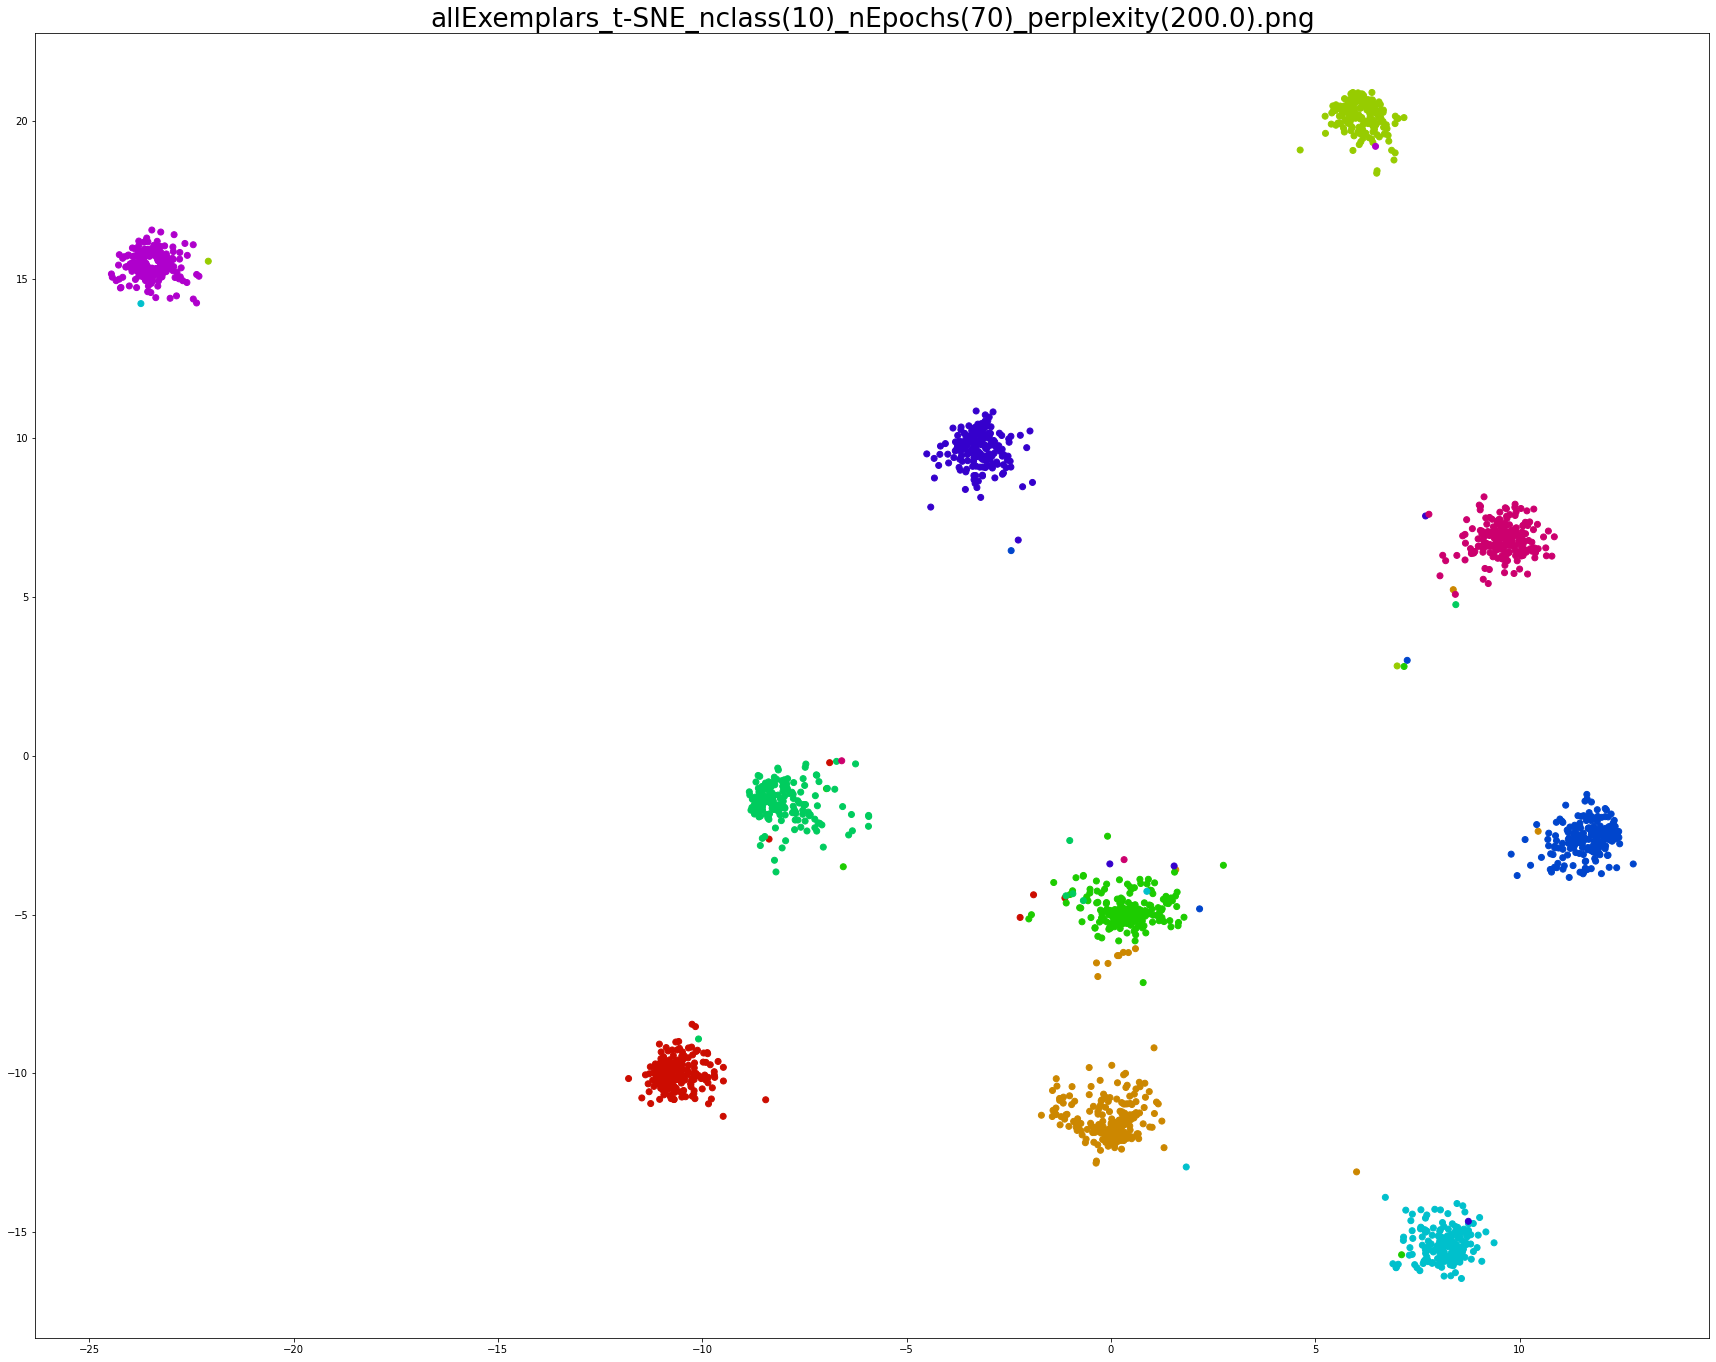

dataX shape and labelsY size...
(2000, 64)
torch.Size([2000])
Creating tSNE Model...
(2000, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


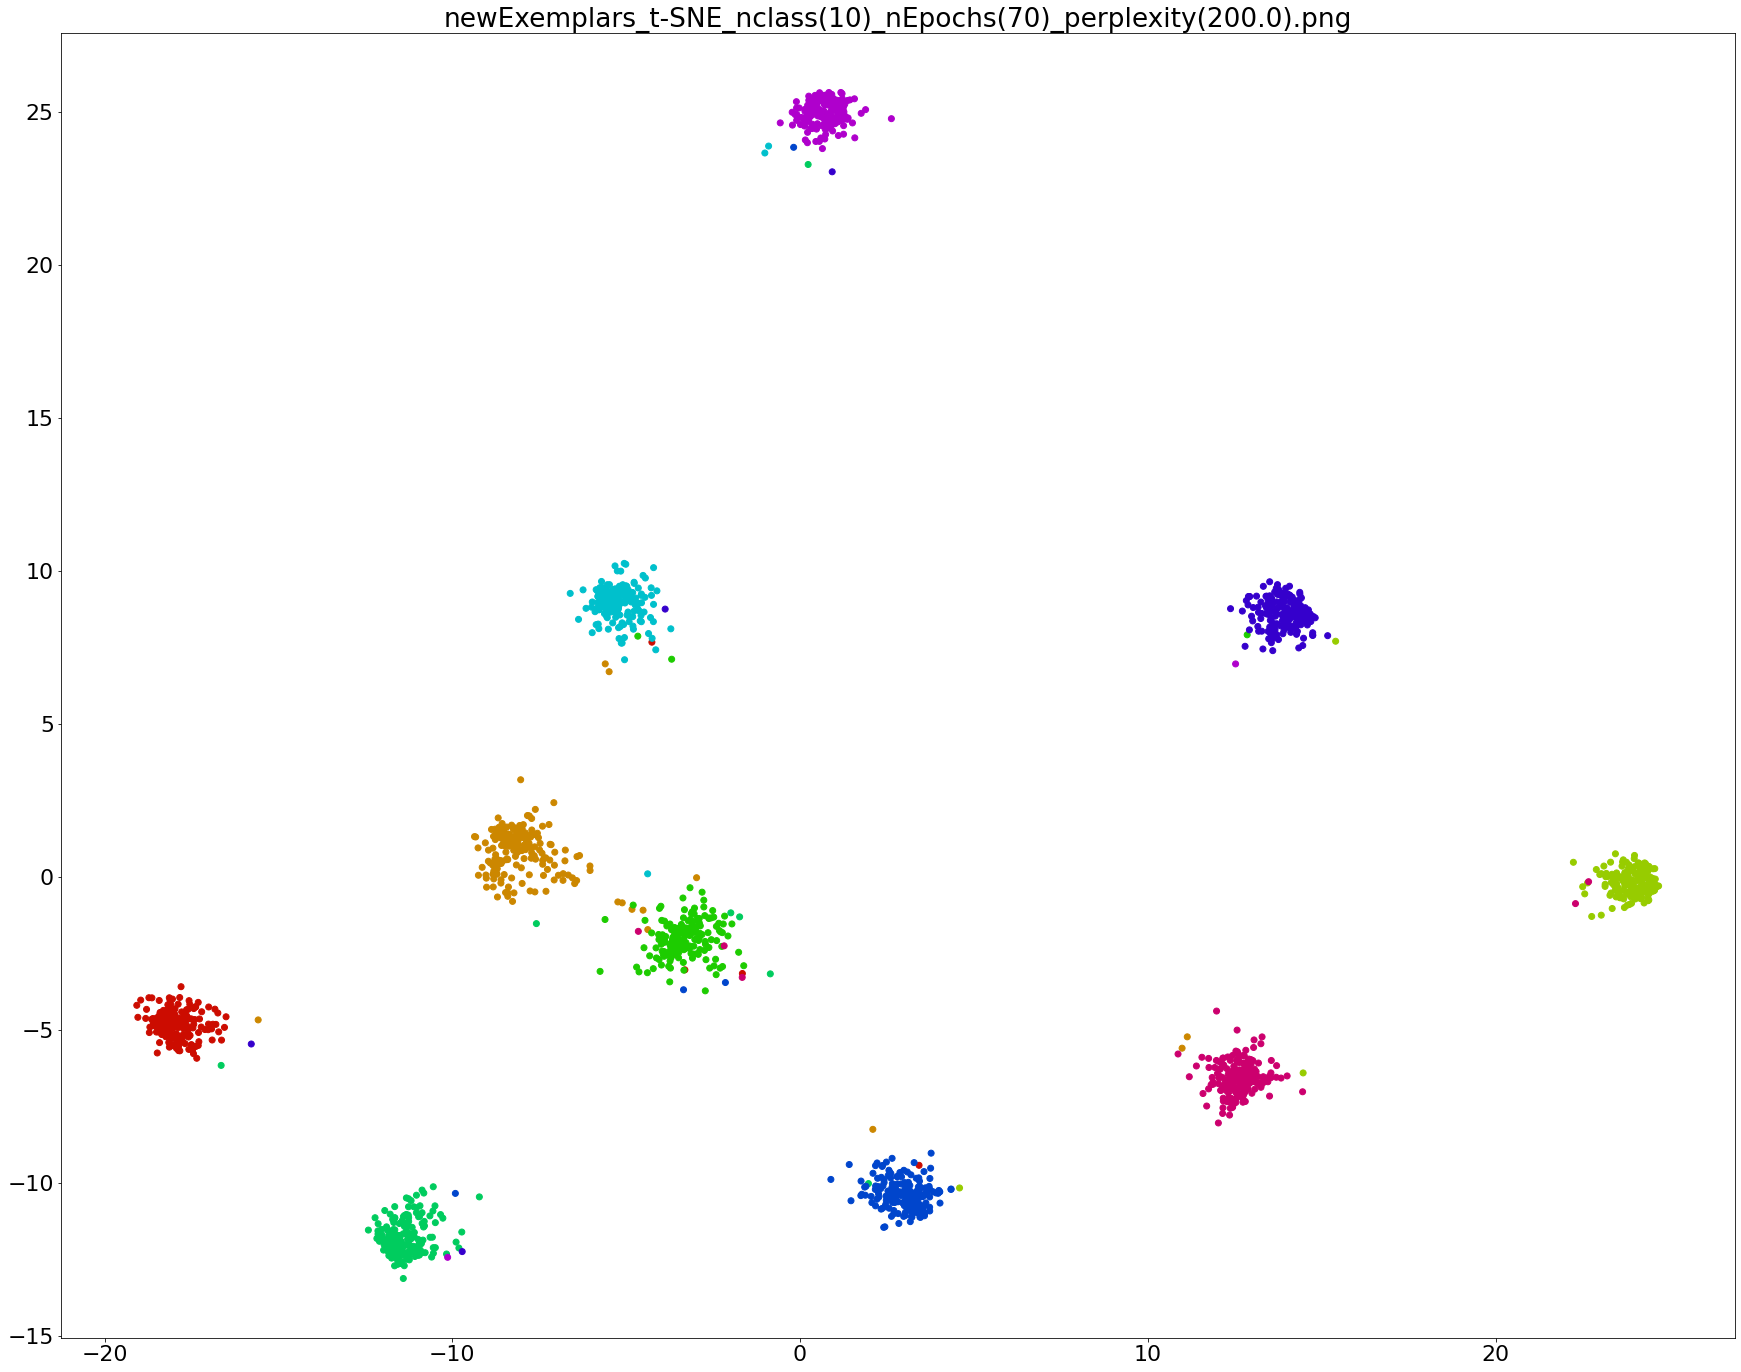

Loading training examples for classes [90, 69, 93, 22, 20, 39, 6, 61, 19, 81]
Batch size: 5000
10 new classes
5000
7000
TRAIN
Epoch [5/70], Average_Loss: 0.1329
Epoch [10/70], Average_Loss: 0.1173
Epoch [15/70], Average_Loss: 0.1080
Epoch [20/70], Average_Loss: 0.1033
Epoch [25/70], Average_Loss: 0.0977
Epoch [30/70], Average_Loss: 0.0925
Epoch [35/70], Average_Loss: 0.0919
Epoch [40/70], Average_Loss: 0.0871
Epoch [45/70], Average_Loss: 0.0878
Epoch [50/70], Average_Loss: 0.0740
Epoch [55/70], Average_Loss: 0.0648
Epoch [60/70], Average_Loss: 0.0625
Epoch [65/70], Average_Loss: 0.0602
Epoch [70/70], Average_Loss: 0.0594
Constructing exemplar set for class-90...
Done exemplars
Constructing exemplar set for class-69...
Done exemplars
Constructing exemplar set for class-93...
Done exemplars
Constructing exemplar set for class-22...
Done exemplars
Constructing exemplar set for class-20...
Done exemplars
Constructing exemplar set for class-39...
Done exemplars
Constructing exemplar set for

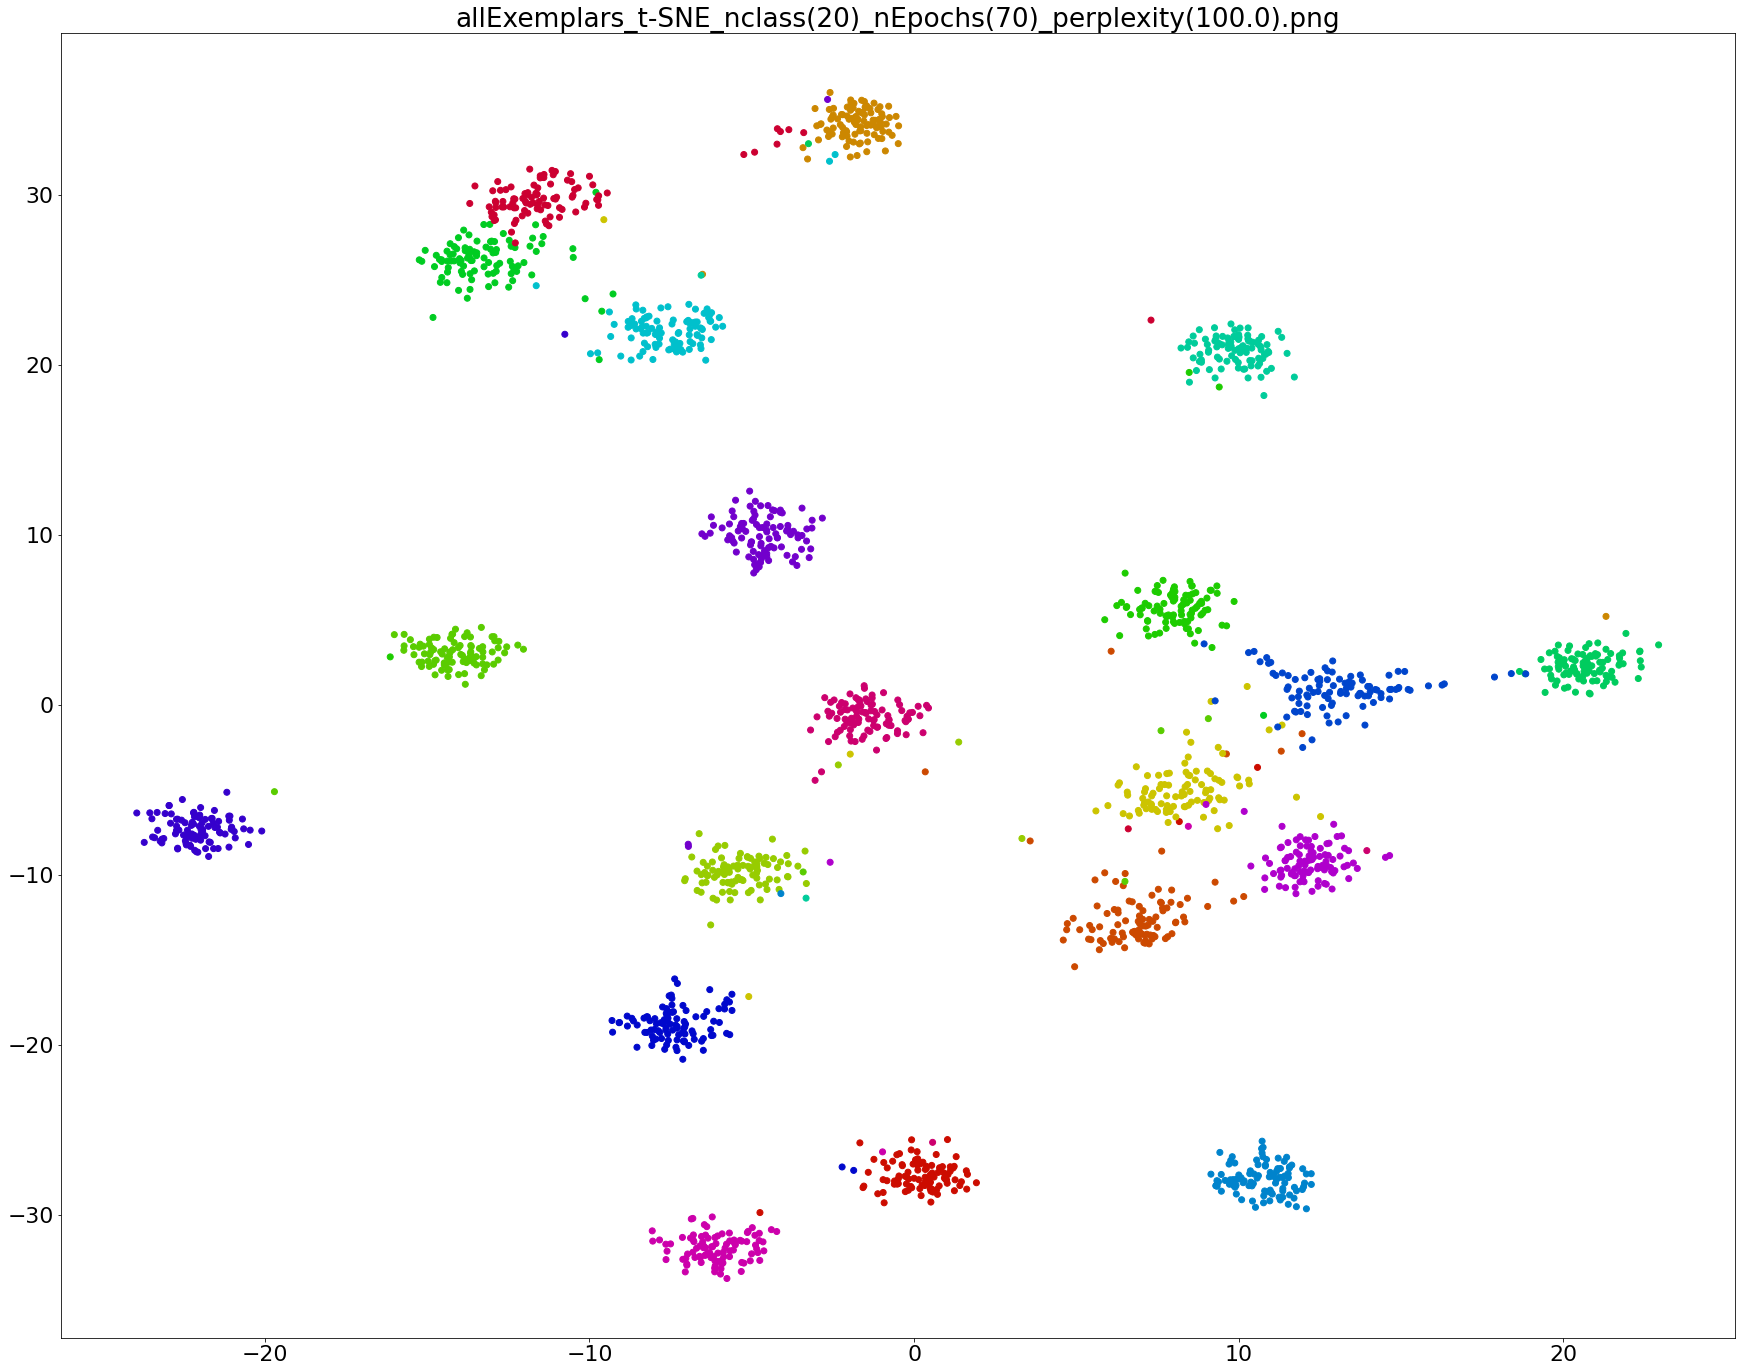

dataX shape and labelsY size...
(1000, 64)
torch.Size([1000])
Creating tSNE Model...
(1000, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


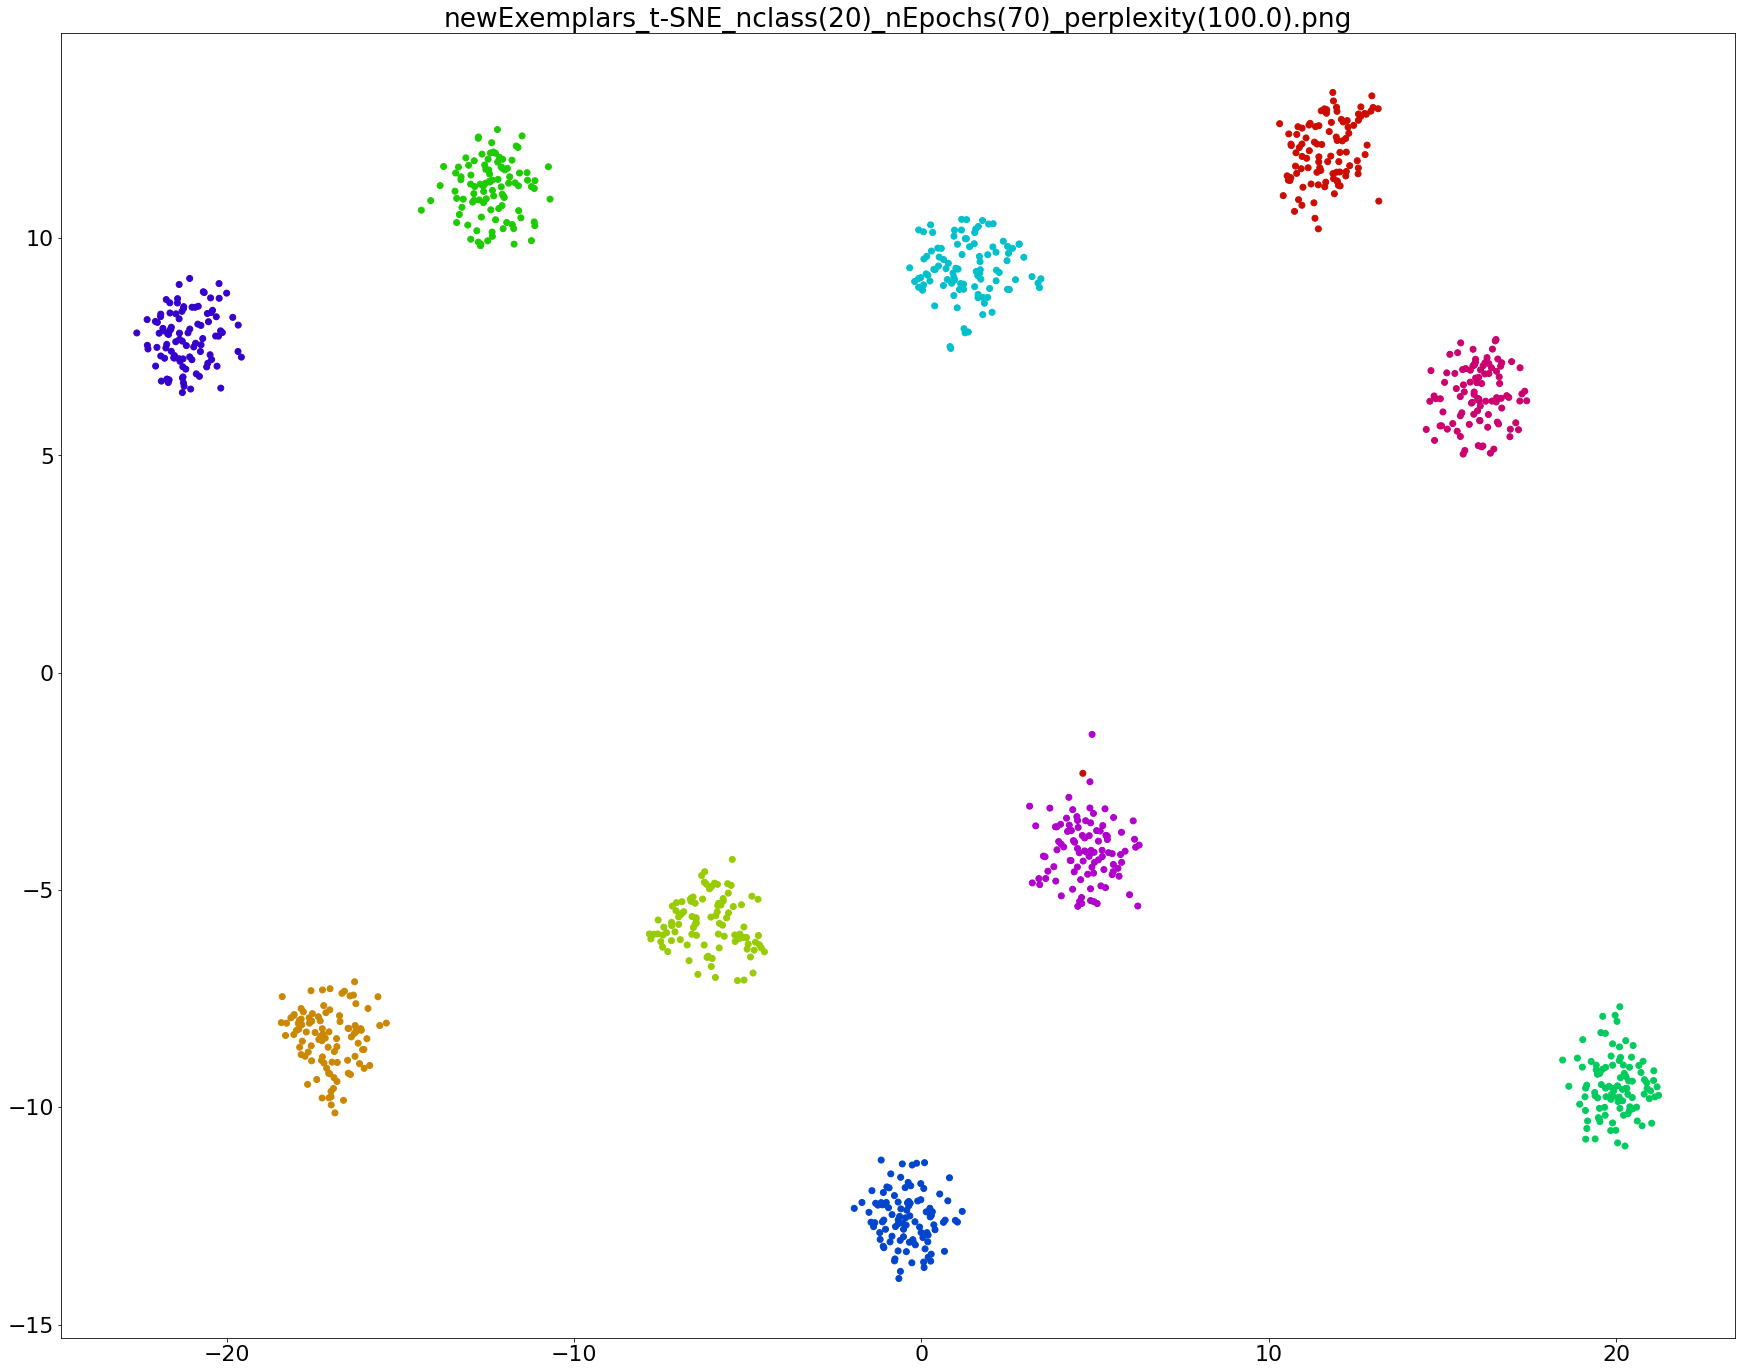

Loading training examples for classes [96, 37, 76, 40, 43, 8, 1, 83, 2, 49]
Batch size: 5000
10 new classes
5000
7000
TRAIN
Epoch [5/70], Average_Loss: 0.1029
Epoch [10/70], Average_Loss: 0.0942
Epoch [15/70], Average_Loss: 0.0896
Epoch [20/70], Average_Loss: 0.0875
Epoch [25/70], Average_Loss: 0.0865
Epoch [30/70], Average_Loss: 0.0841
Epoch [35/70], Average_Loss: 0.0825
Epoch [40/70], Average_Loss: 0.0830
Epoch [45/70], Average_Loss: 0.0811
Epoch [50/70], Average_Loss: 0.0745
Epoch [55/70], Average_Loss: 0.0674
Epoch [60/70], Average_Loss: 0.0669
Epoch [65/70], Average_Loss: 0.0655
Epoch [70/70], Average_Loss: 0.0655
Constructing exemplar set for class-96...
Done exemplars
Constructing exemplar set for class-37...
Done exemplars
Constructing exemplar set for class-76...
Done exemplars
Constructing exemplar set for class-40...
Done exemplars
Constructing exemplar set for class-43...
Done exemplars
Constructing exemplar set for class-8...
Done exemplars
Constructing exemplar set for cl

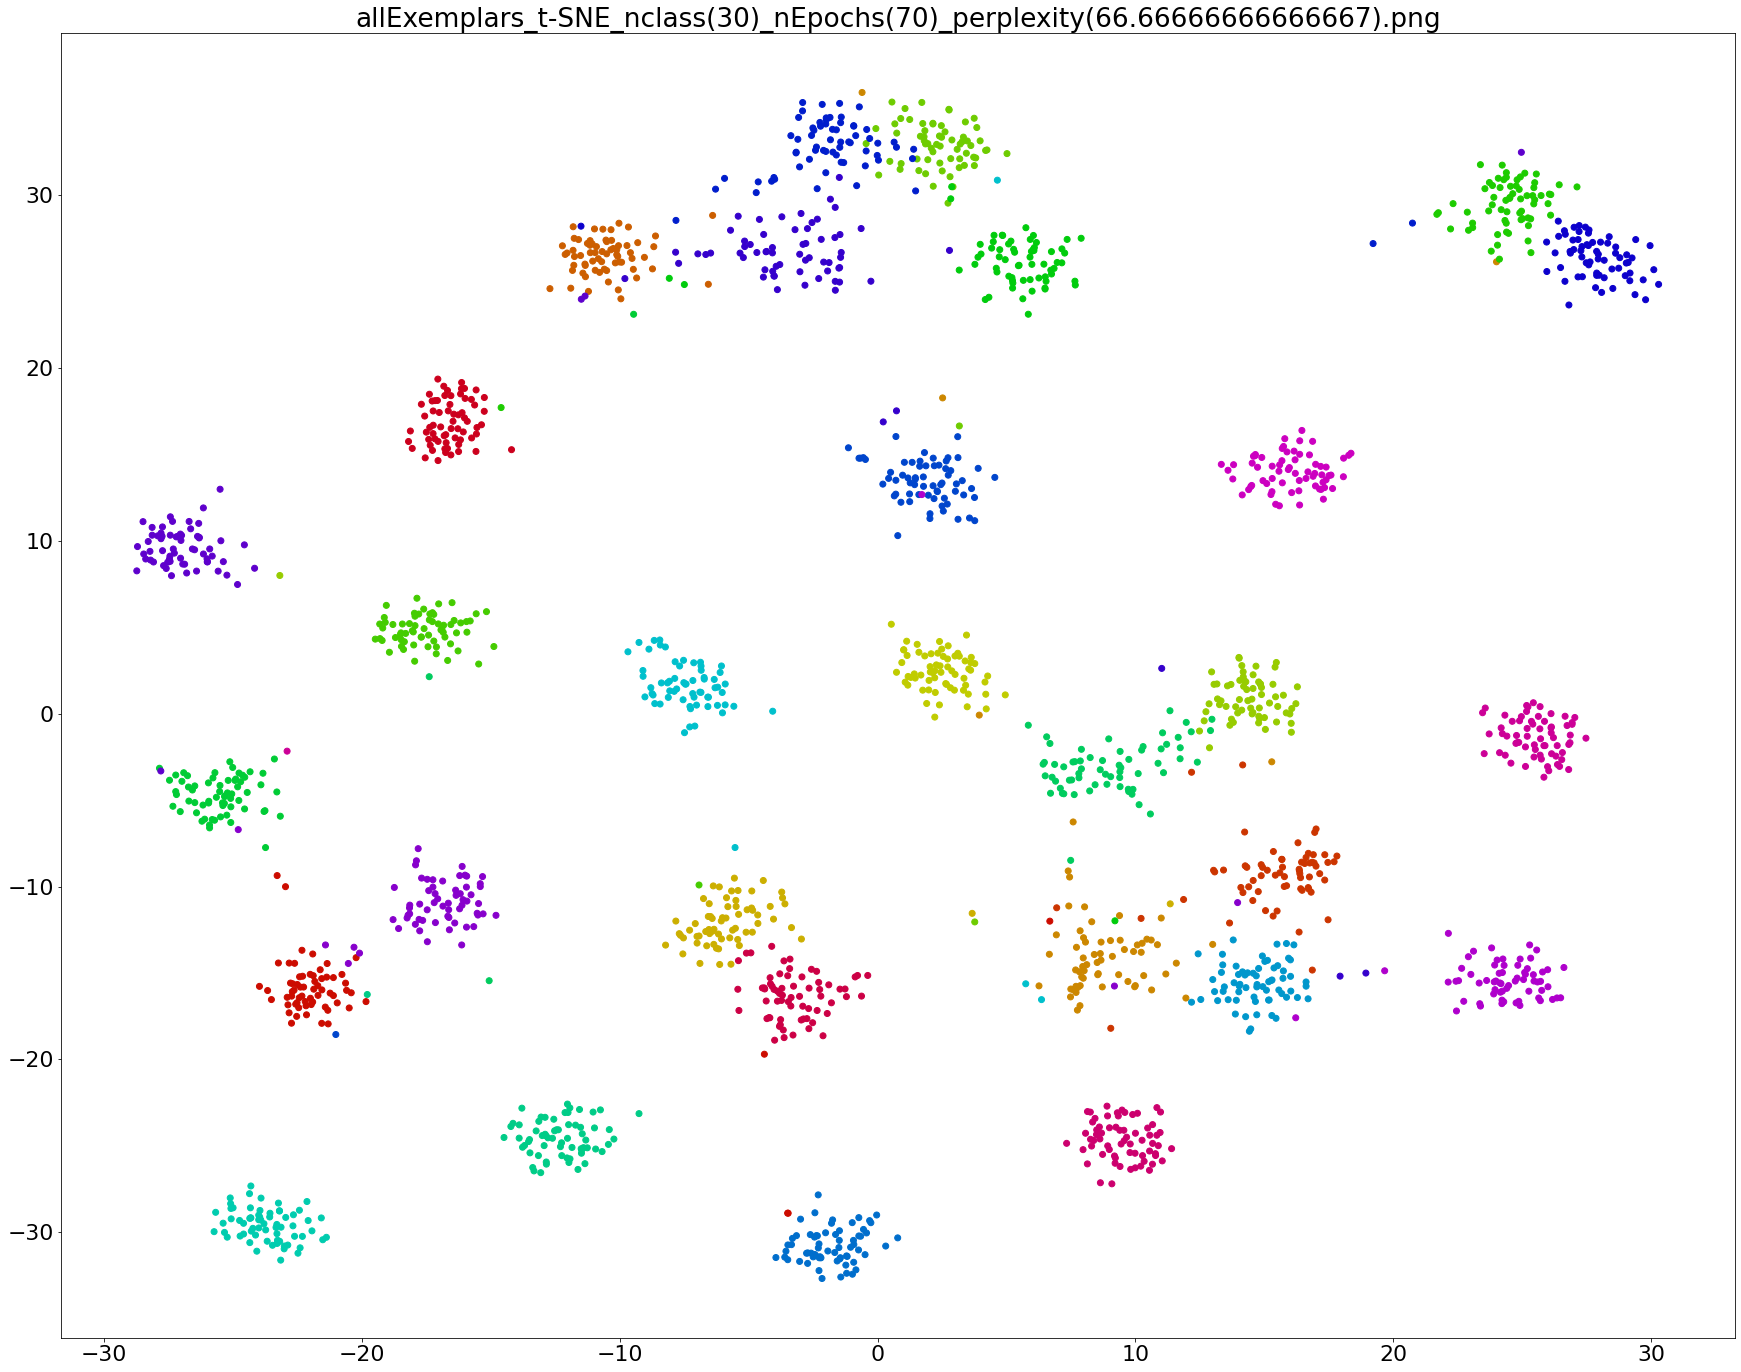

dataX shape and labelsY size...
(660, 64)
torch.Size([660])
Creating tSNE Model...
(660, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


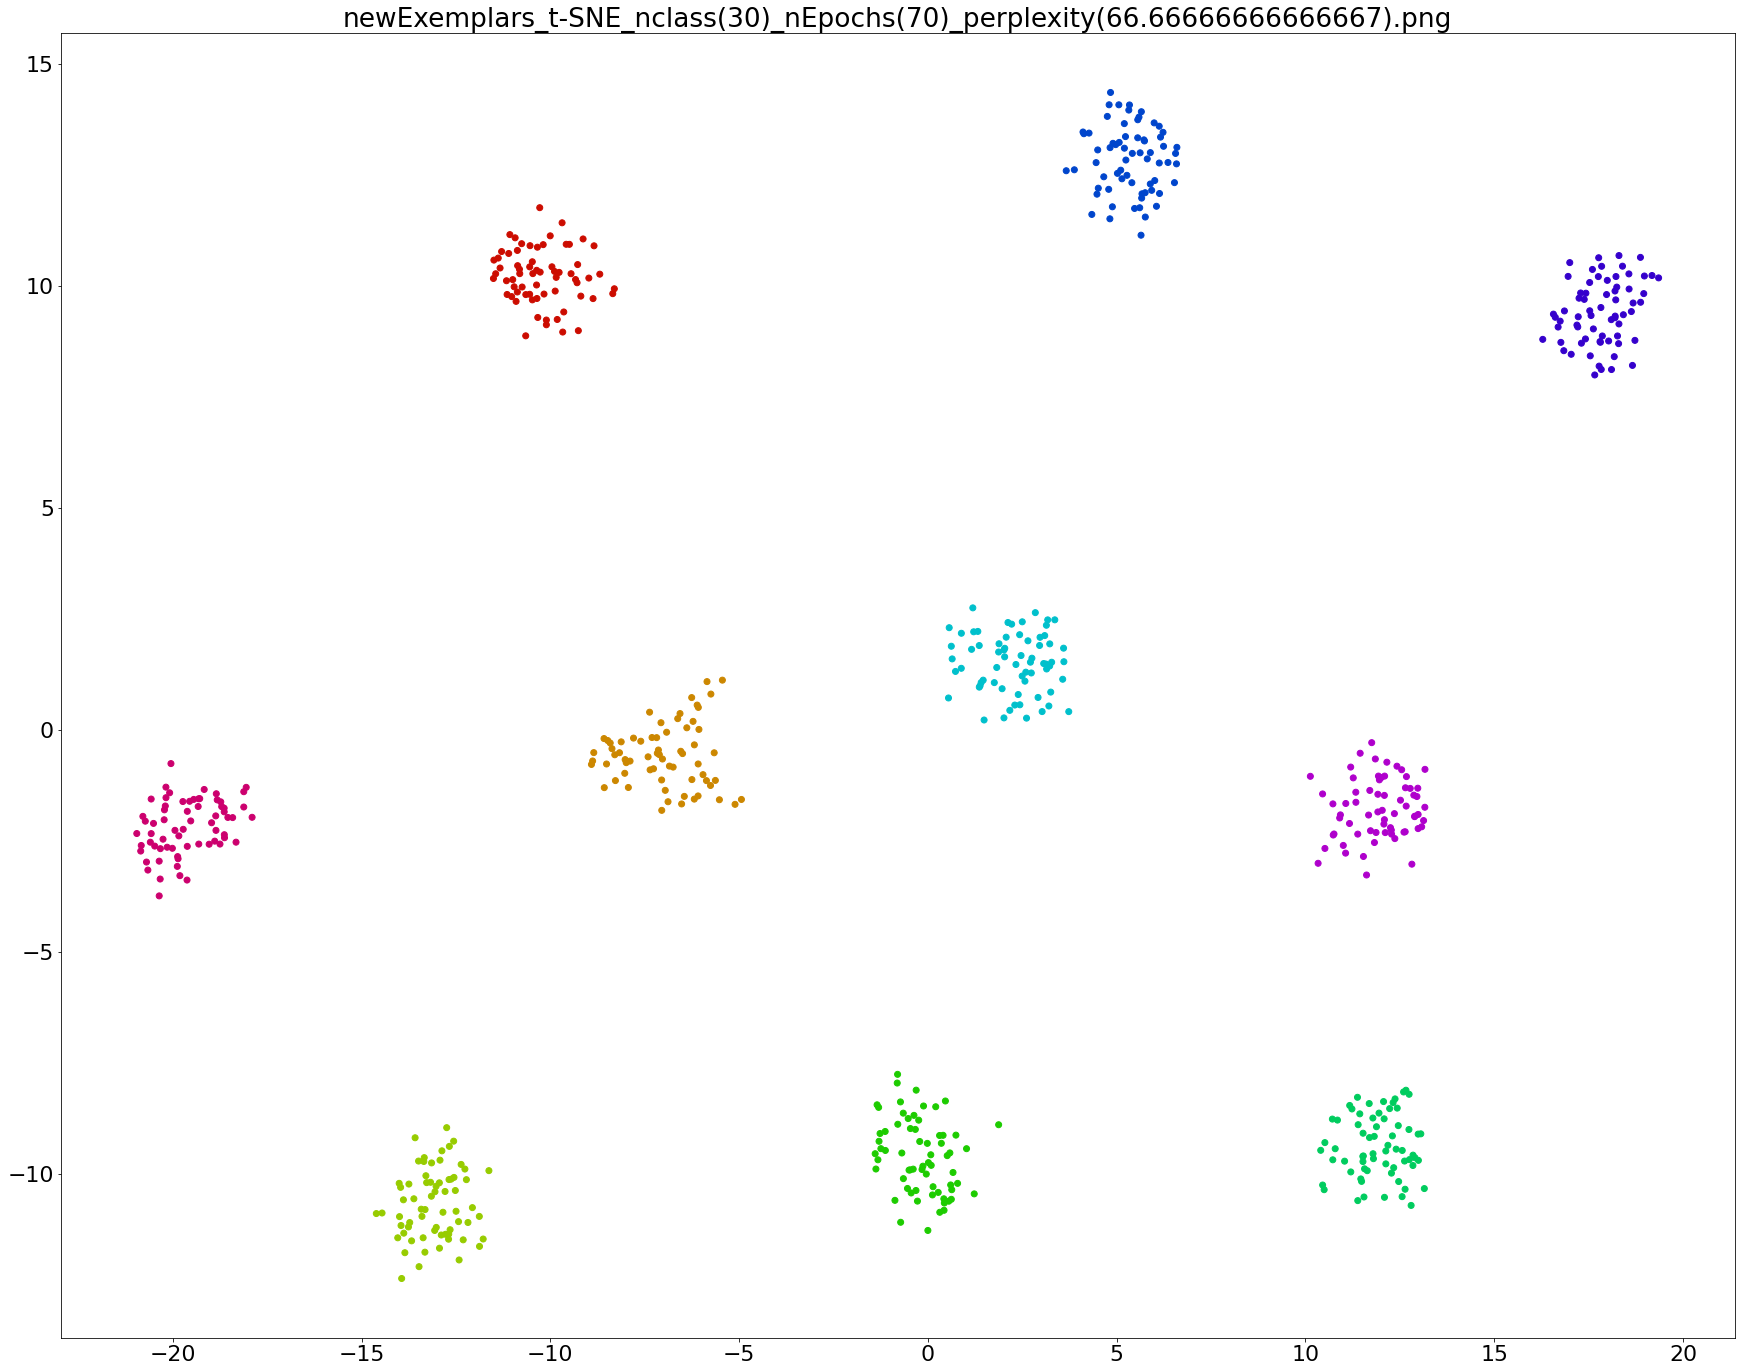

Loading training examples for classes [12, 27, 68, 29, 80, 86, 24, 11, 26, 51]
Batch size: 5000
10 new classes
5000
6980
TRAIN
Epoch [5/70], Average_Loss: 0.1008
Epoch [10/70], Average_Loss: 0.0951
Epoch [15/70], Average_Loss: 0.0934
Epoch [20/70], Average_Loss: 0.0910
Epoch [25/70], Average_Loss: 0.0893
Epoch [30/70], Average_Loss: 0.0879
Epoch [35/70], Average_Loss: 0.0870
Epoch [40/70], Average_Loss: 0.0856
Epoch [45/70], Average_Loss: 0.0862
Epoch [50/70], Average_Loss: 0.0782
Epoch [55/70], Average_Loss: 0.0734
Epoch [60/70], Average_Loss: 0.0726
Epoch [65/70], Average_Loss: 0.0714
Epoch [70/70], Average_Loss: 0.0711
Constructing exemplar set for class-12...
Done exemplars
Constructing exemplar set for class-27...
Done exemplars
Constructing exemplar set for class-68...
Done exemplars
Constructing exemplar set for class-29...
Done exemplars
Constructing exemplar set for class-80...
Done exemplars
Constructing exemplar set for class-86...
Done exemplars
Constructing exemplar set fo

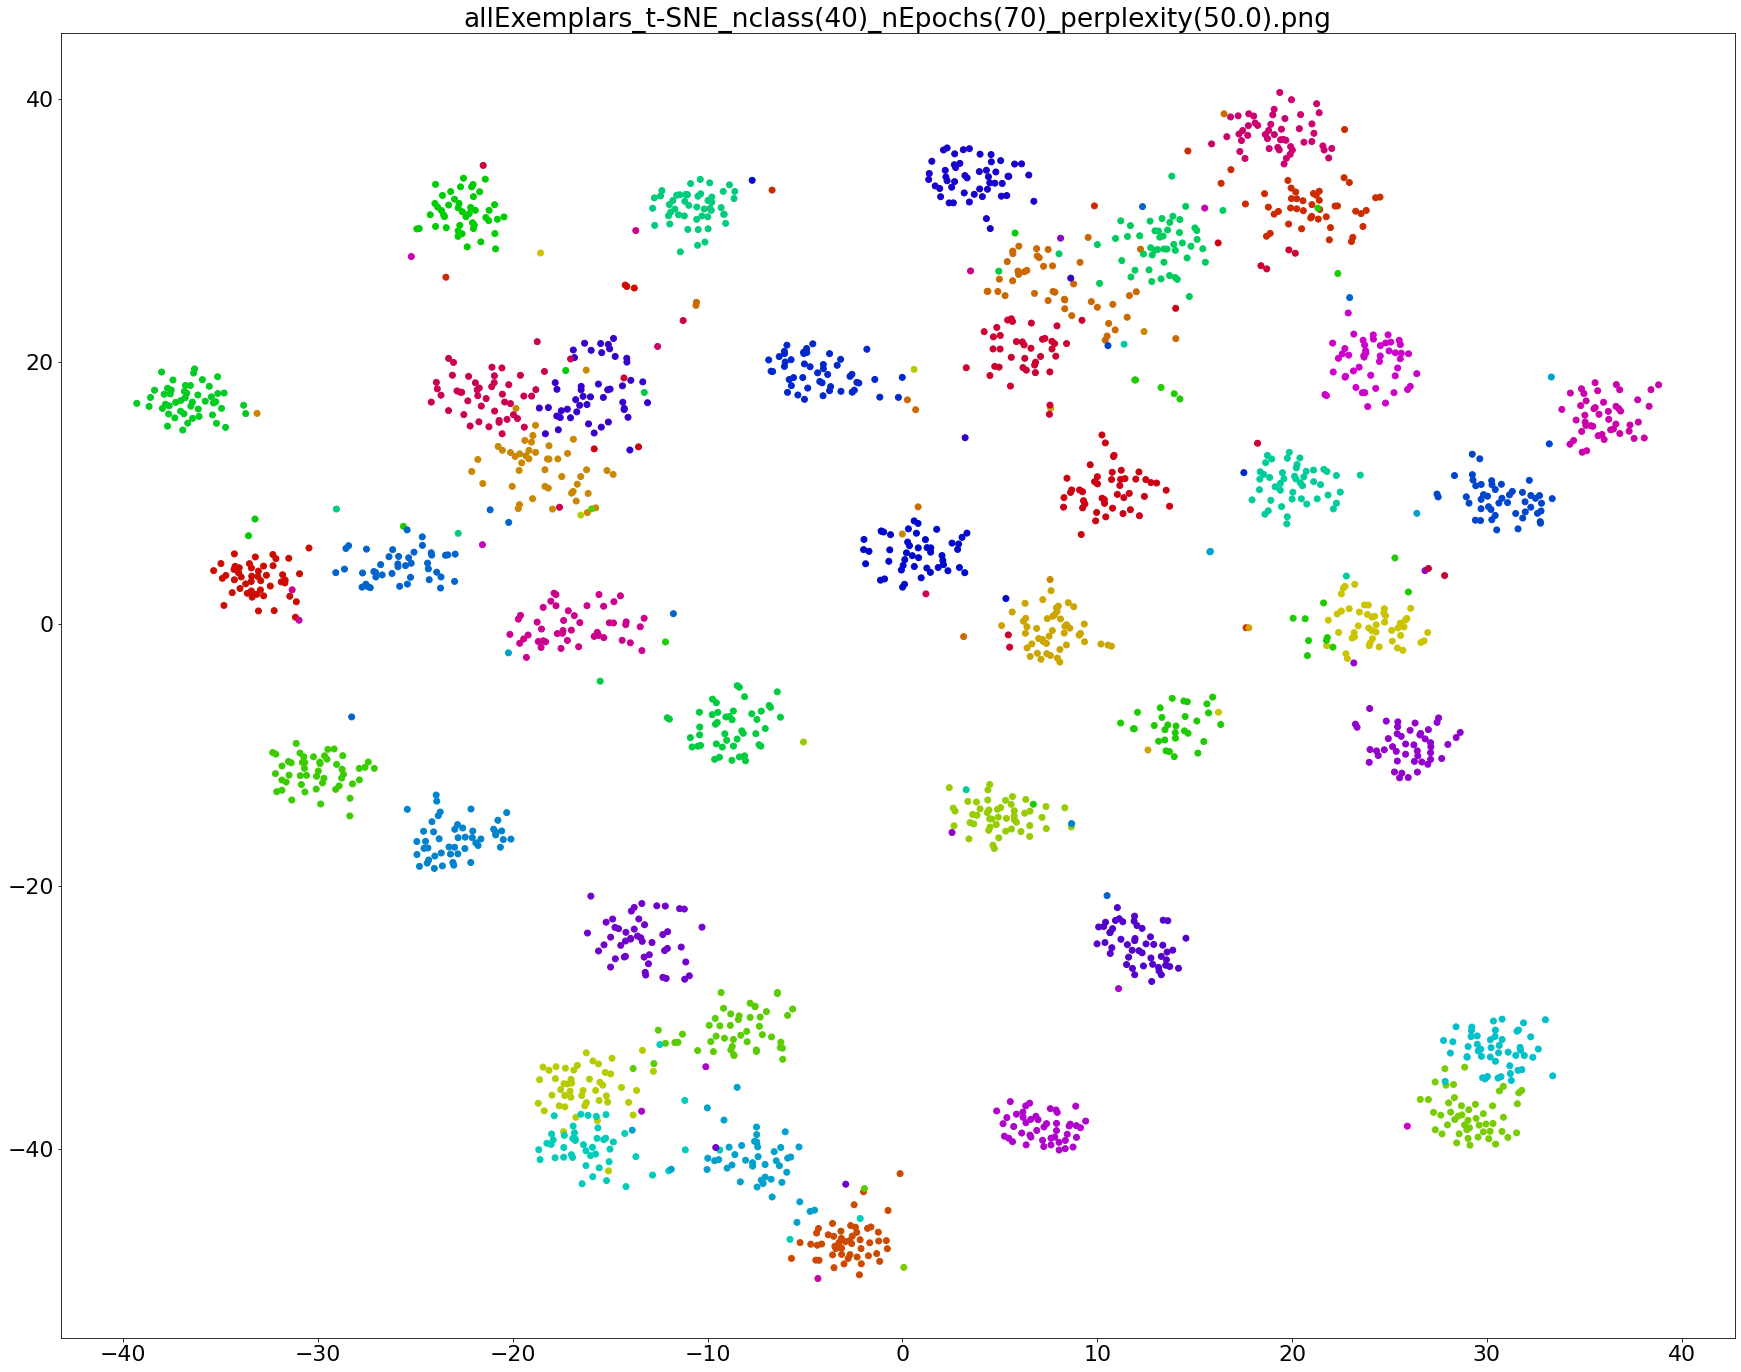

dataX shape and labelsY size...
(500, 64)
torch.Size([500])
Creating tSNE Model...
(500, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


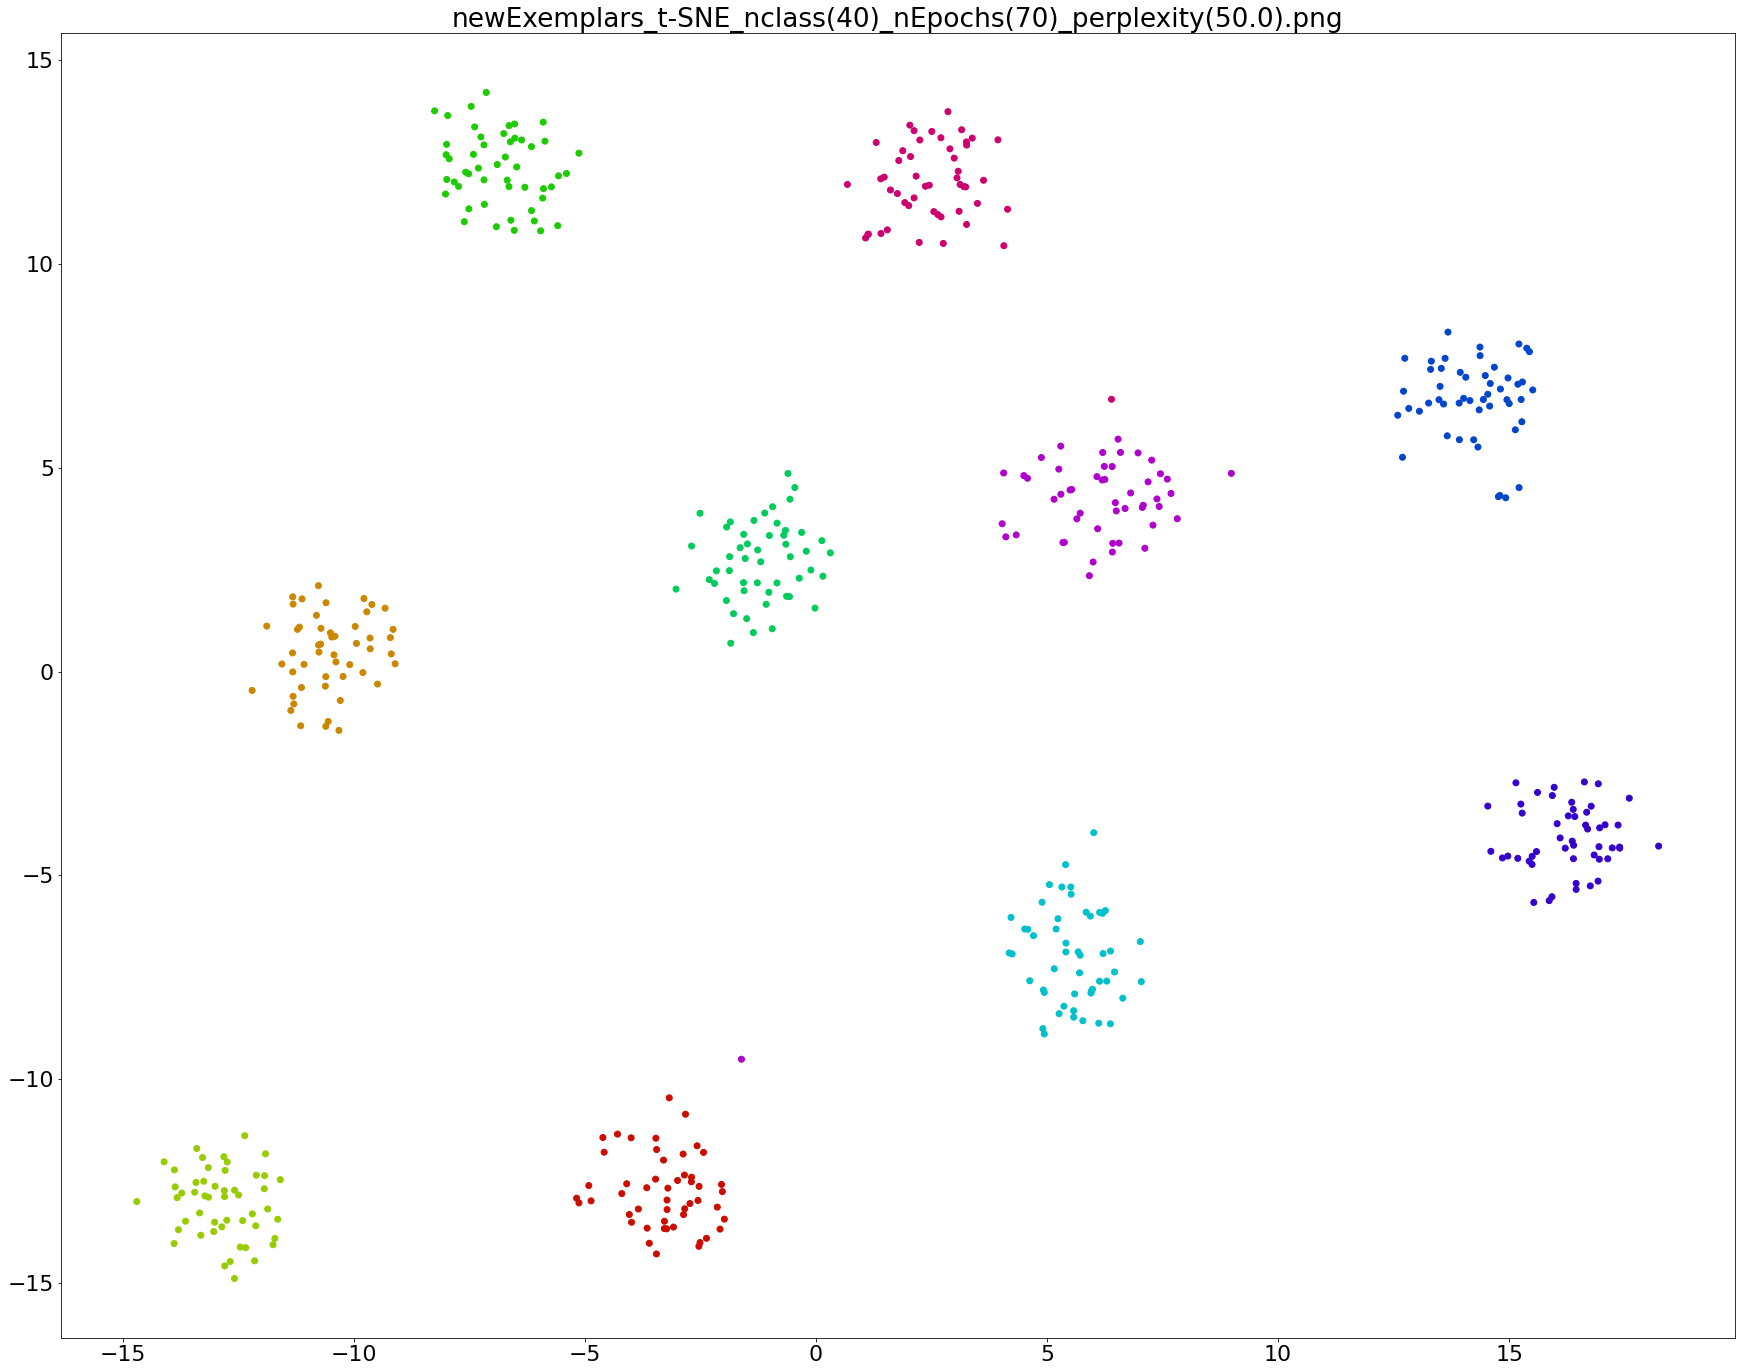

Loading training examples for classes [82, 16, 72, 52, 60, 36, 14, 41, 73, 38]
Batch size: 5000
10 new classes
5000
7000
TRAIN
Epoch [5/70], Average_Loss: 0.0907
Epoch [10/70], Average_Loss: 0.0877
Epoch [15/70], Average_Loss: 0.0861
Epoch [20/70], Average_Loss: 0.0848
Epoch [25/70], Average_Loss: 0.0836
Epoch [30/70], Average_Loss: 0.0836
Epoch [35/70], Average_Loss: 0.0835
Epoch [40/70], Average_Loss: 0.0825
Epoch [45/70], Average_Loss: 0.0816
Epoch [50/70], Average_Loss: 0.0774
Epoch [55/70], Average_Loss: 0.0742
Epoch [60/70], Average_Loss: 0.0733
Epoch [65/70], Average_Loss: 0.0726
Epoch [70/70], Average_Loss: 0.0723
Constructing exemplar set for class-82...
Done exemplars
Constructing exemplar set for class-16...
Done exemplars
Constructing exemplar set for class-72...
Done exemplars
Constructing exemplar set for class-52...
Done exemplars
Constructing exemplar set for class-60...
Done exemplars
Constructing exemplar set for class-36...
Done exemplars
Constructing exemplar set fo

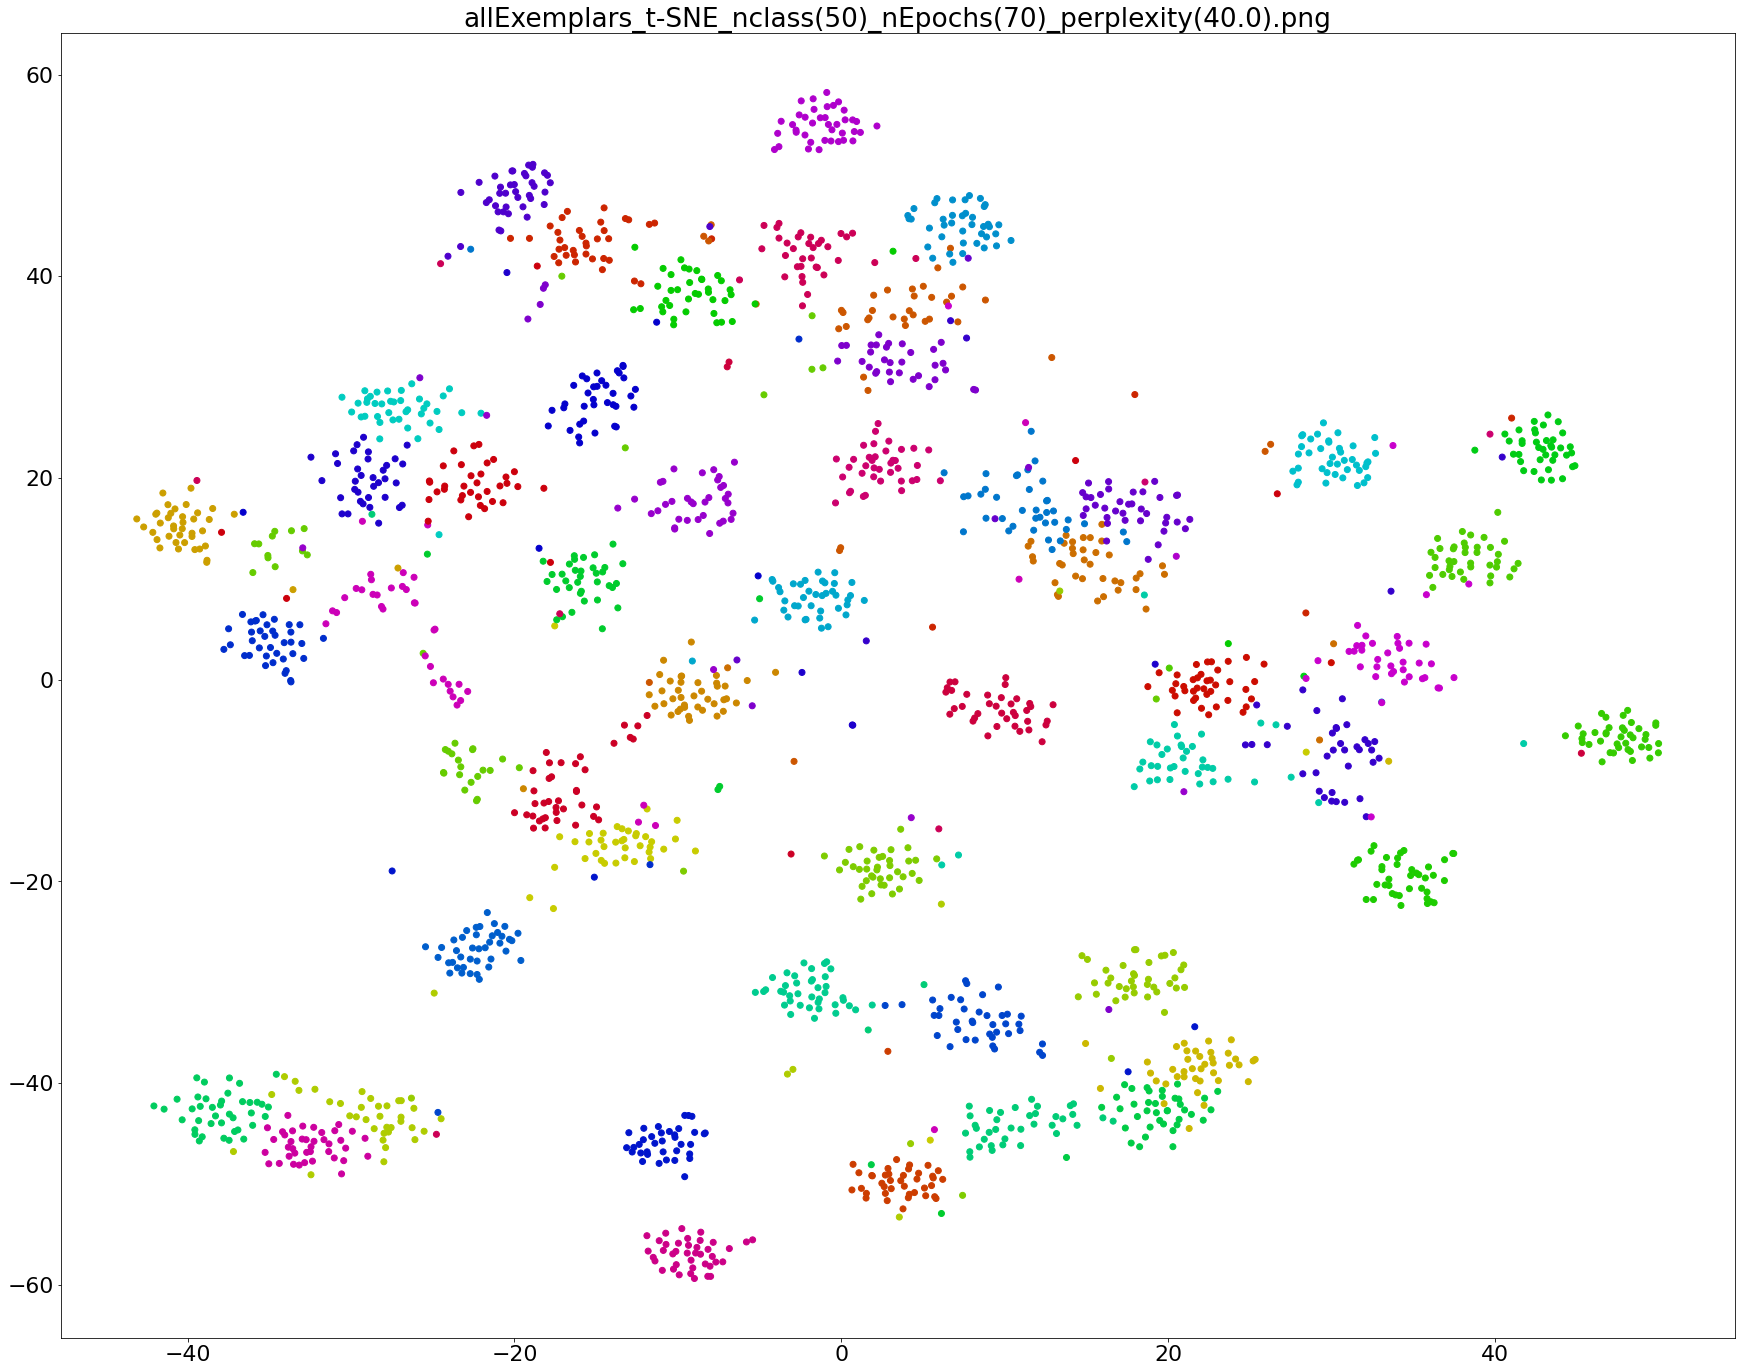

dataX shape and labelsY size...
(400, 64)
torch.Size([400])
Creating tSNE Model...
(400, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


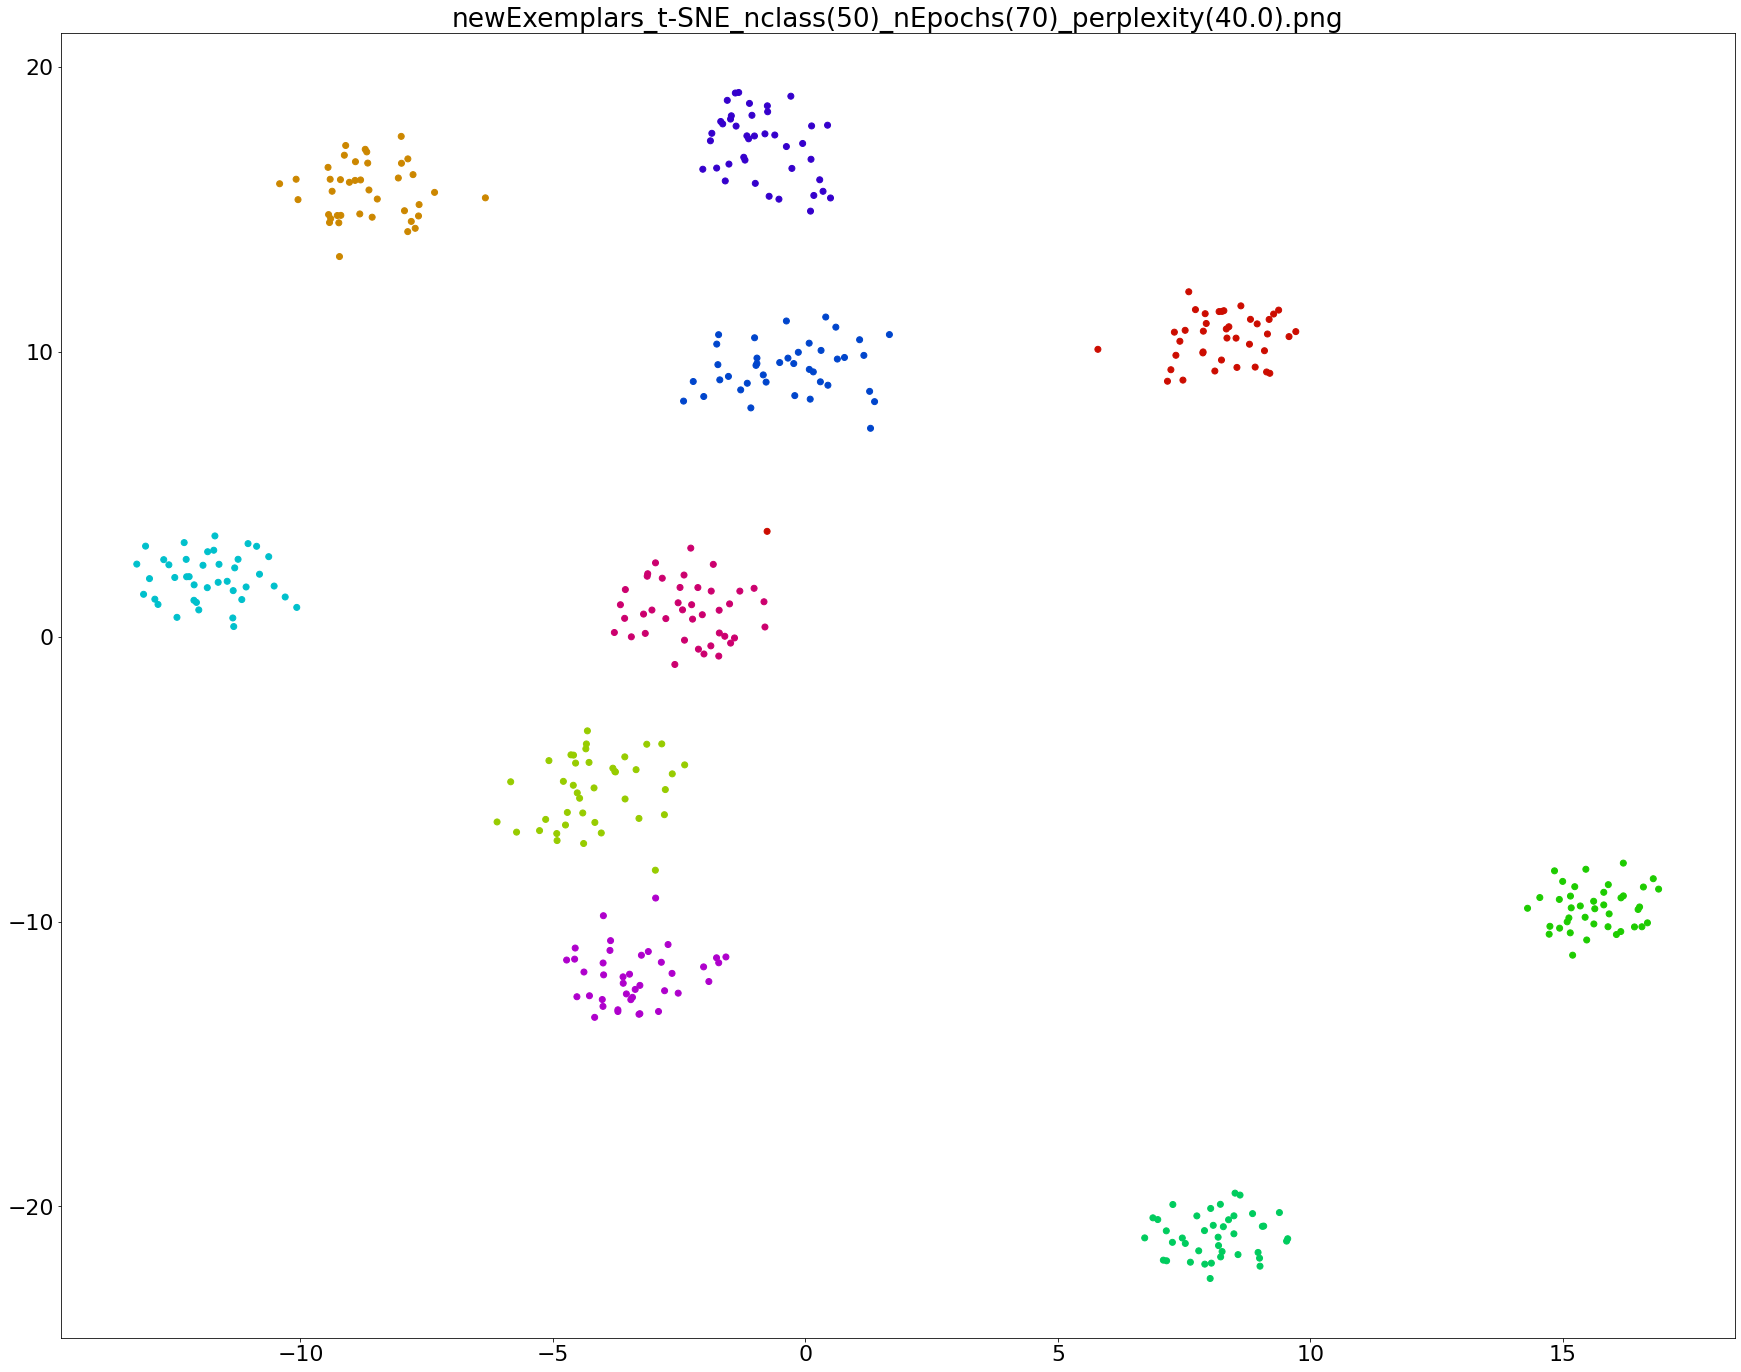

Loading training examples for classes [79, 50, 94, 54, 42, 15, 87, 5, 75, 78]
Batch size: 5000
10 new classes
5000
7000
TRAIN
Epoch [5/70], Average_Loss: 0.0975
Epoch [10/70], Average_Loss: 0.0948
Epoch [15/70], Average_Loss: 0.0936
Epoch [20/70], Average_Loss: 0.0923
Epoch [25/70], Average_Loss: 0.0910
Epoch [30/70], Average_Loss: 0.0898
Epoch [35/70], Average_Loss: 0.0893
Epoch [40/70], Average_Loss: 0.0891
Epoch [45/70], Average_Loss: 0.0893
Epoch [50/70], Average_Loss: 0.0844
Epoch [55/70], Average_Loss: 0.0815
Epoch [60/70], Average_Loss: 0.0806
Epoch [65/70], Average_Loss: 0.0800
Epoch [70/70], Average_Loss: 0.0798
Constructing exemplar set for class-79...
Done exemplars
Constructing exemplar set for class-50...
Done exemplars
Constructing exemplar set for class-94...
Done exemplars
Constructing exemplar set for class-54...
Done exemplars
Constructing exemplar set for class-42...
Done exemplars
Constructing exemplar set for class-15...
Done exemplars
Constructing exemplar set for

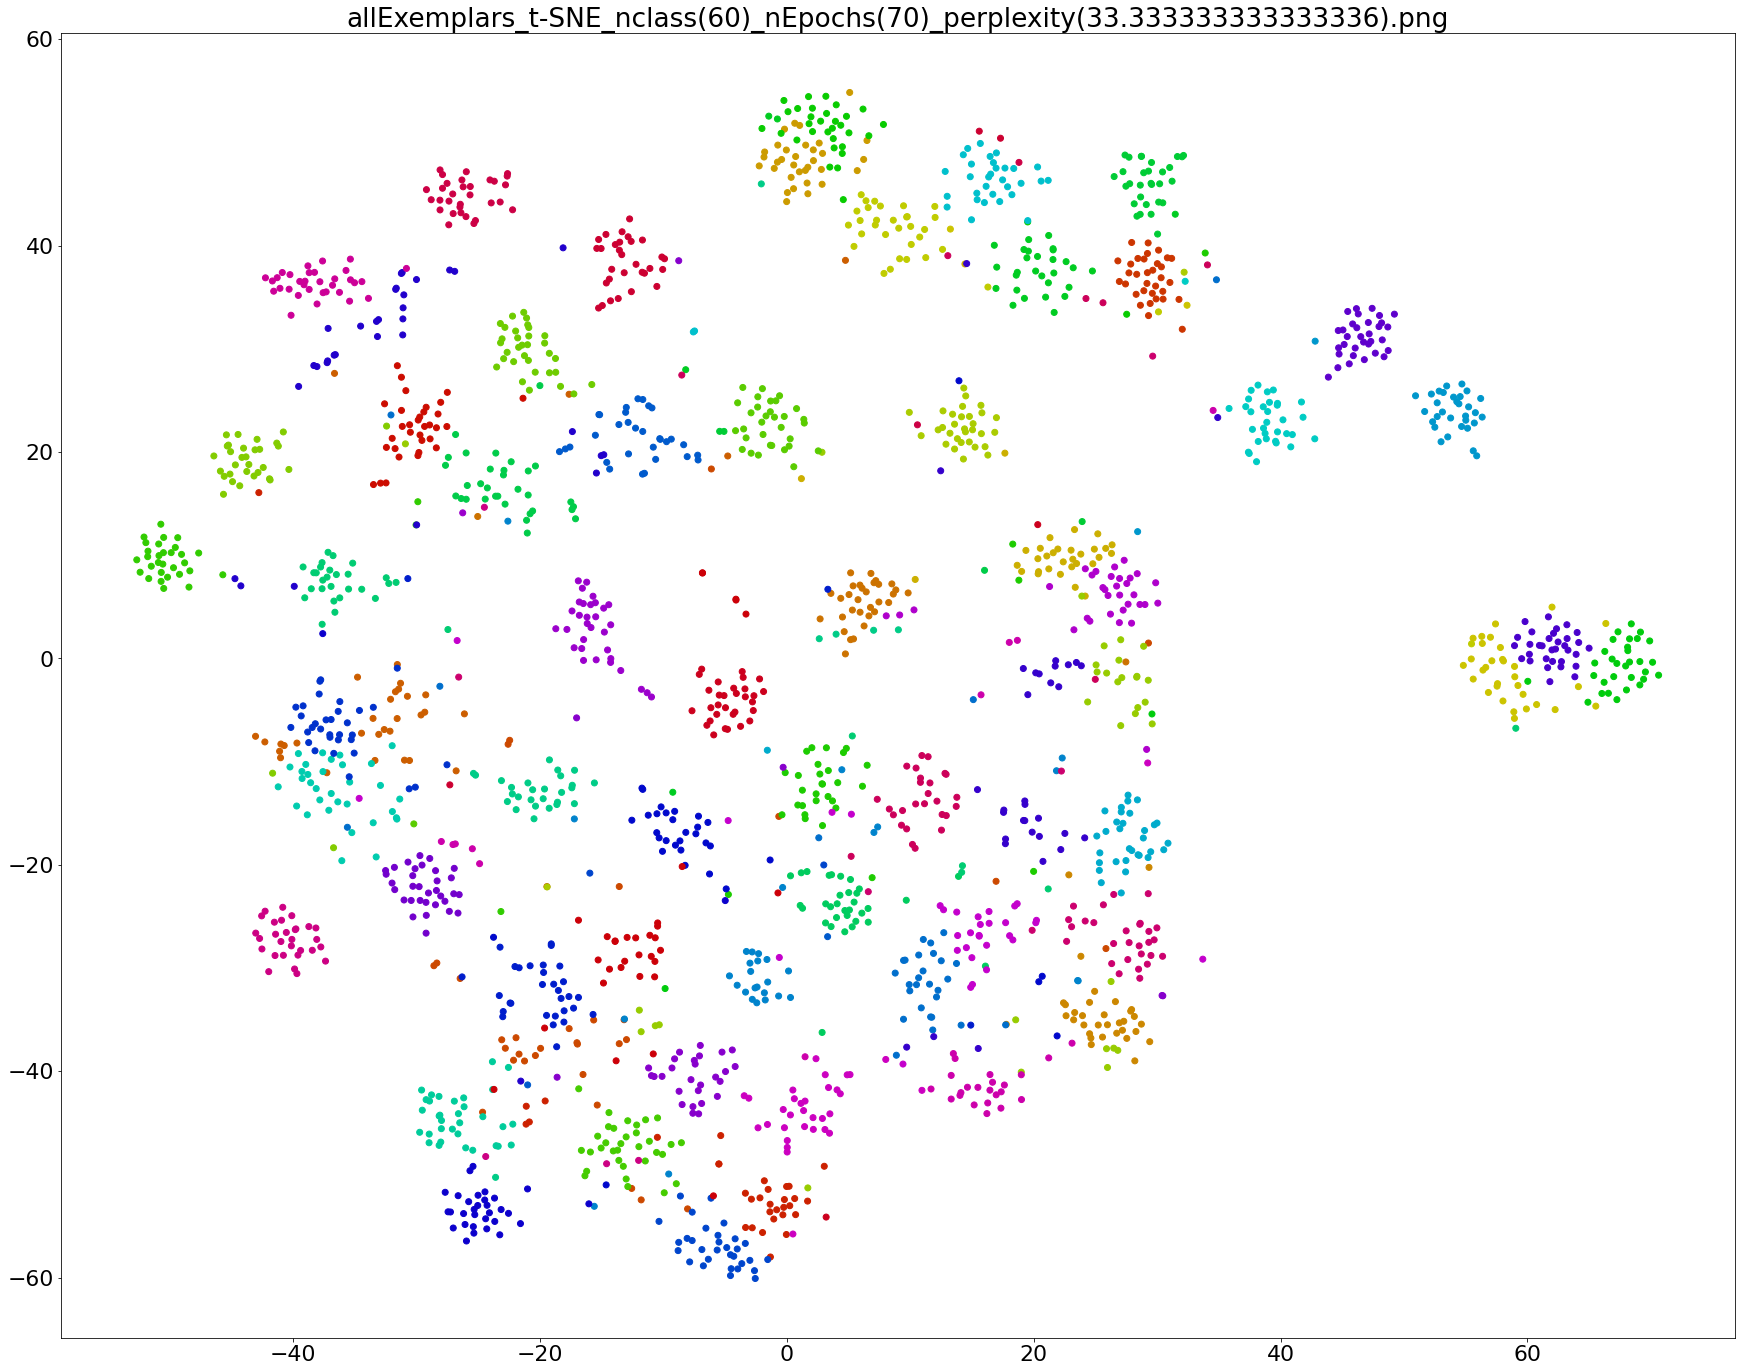

dataX shape and labelsY size...
(330, 64)
torch.Size([330])
Creating tSNE Model...
(330, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


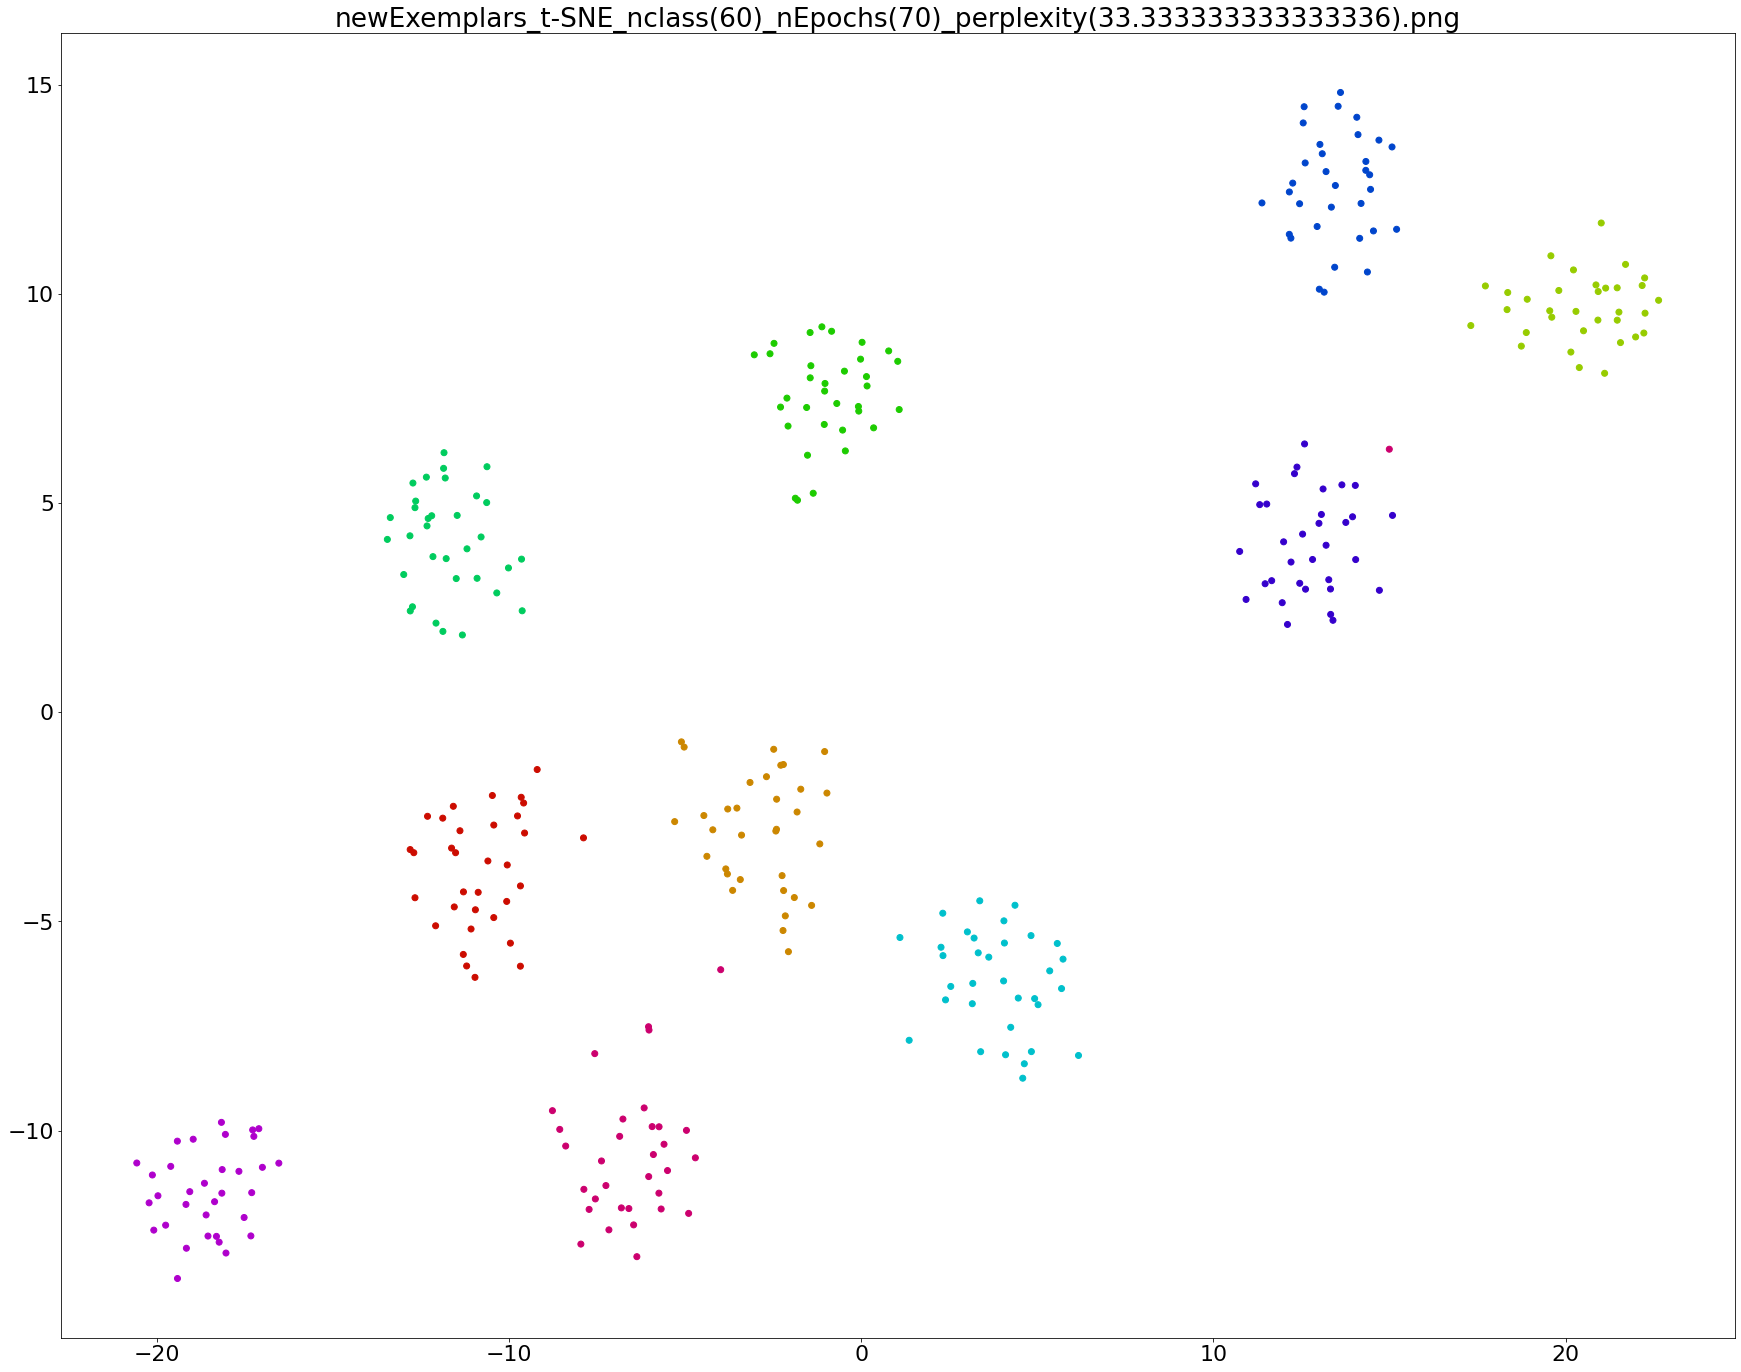

Loading training examples for classes [35, 66, 99, 98, 3, 58, 77, 71, 23, 47]
Batch size: 5000
10 new classes
5000
6980
TRAIN
Epoch [5/70], Average_Loss: 0.0893
Epoch [10/70], Average_Loss: 0.0873
Epoch [15/70], Average_Loss: 0.0858
Epoch [20/70], Average_Loss: 0.0853
Epoch [25/70], Average_Loss: 0.0854
Epoch [30/70], Average_Loss: 0.0831
Epoch [35/70], Average_Loss: 0.0846
Epoch [40/70], Average_Loss: 0.0838
Epoch [45/70], Average_Loss: 0.0834
Epoch [50/70], Average_Loss: 0.0798
Epoch [55/70], Average_Loss: 0.0767
Epoch [60/70], Average_Loss: 0.0758
Epoch [65/70], Average_Loss: 0.0757
Epoch [70/70], Average_Loss: 0.0757
Constructing exemplar set for class-35...
Done exemplars
Constructing exemplar set for class-66...
Done exemplars
Constructing exemplar set for class-99...
Done exemplars
Constructing exemplar set for class-98...
Done exemplars
Constructing exemplar set for class-3...
Done exemplars
Constructing exemplar set for class-58...
Done exemplars
Constructing exemplar set for 

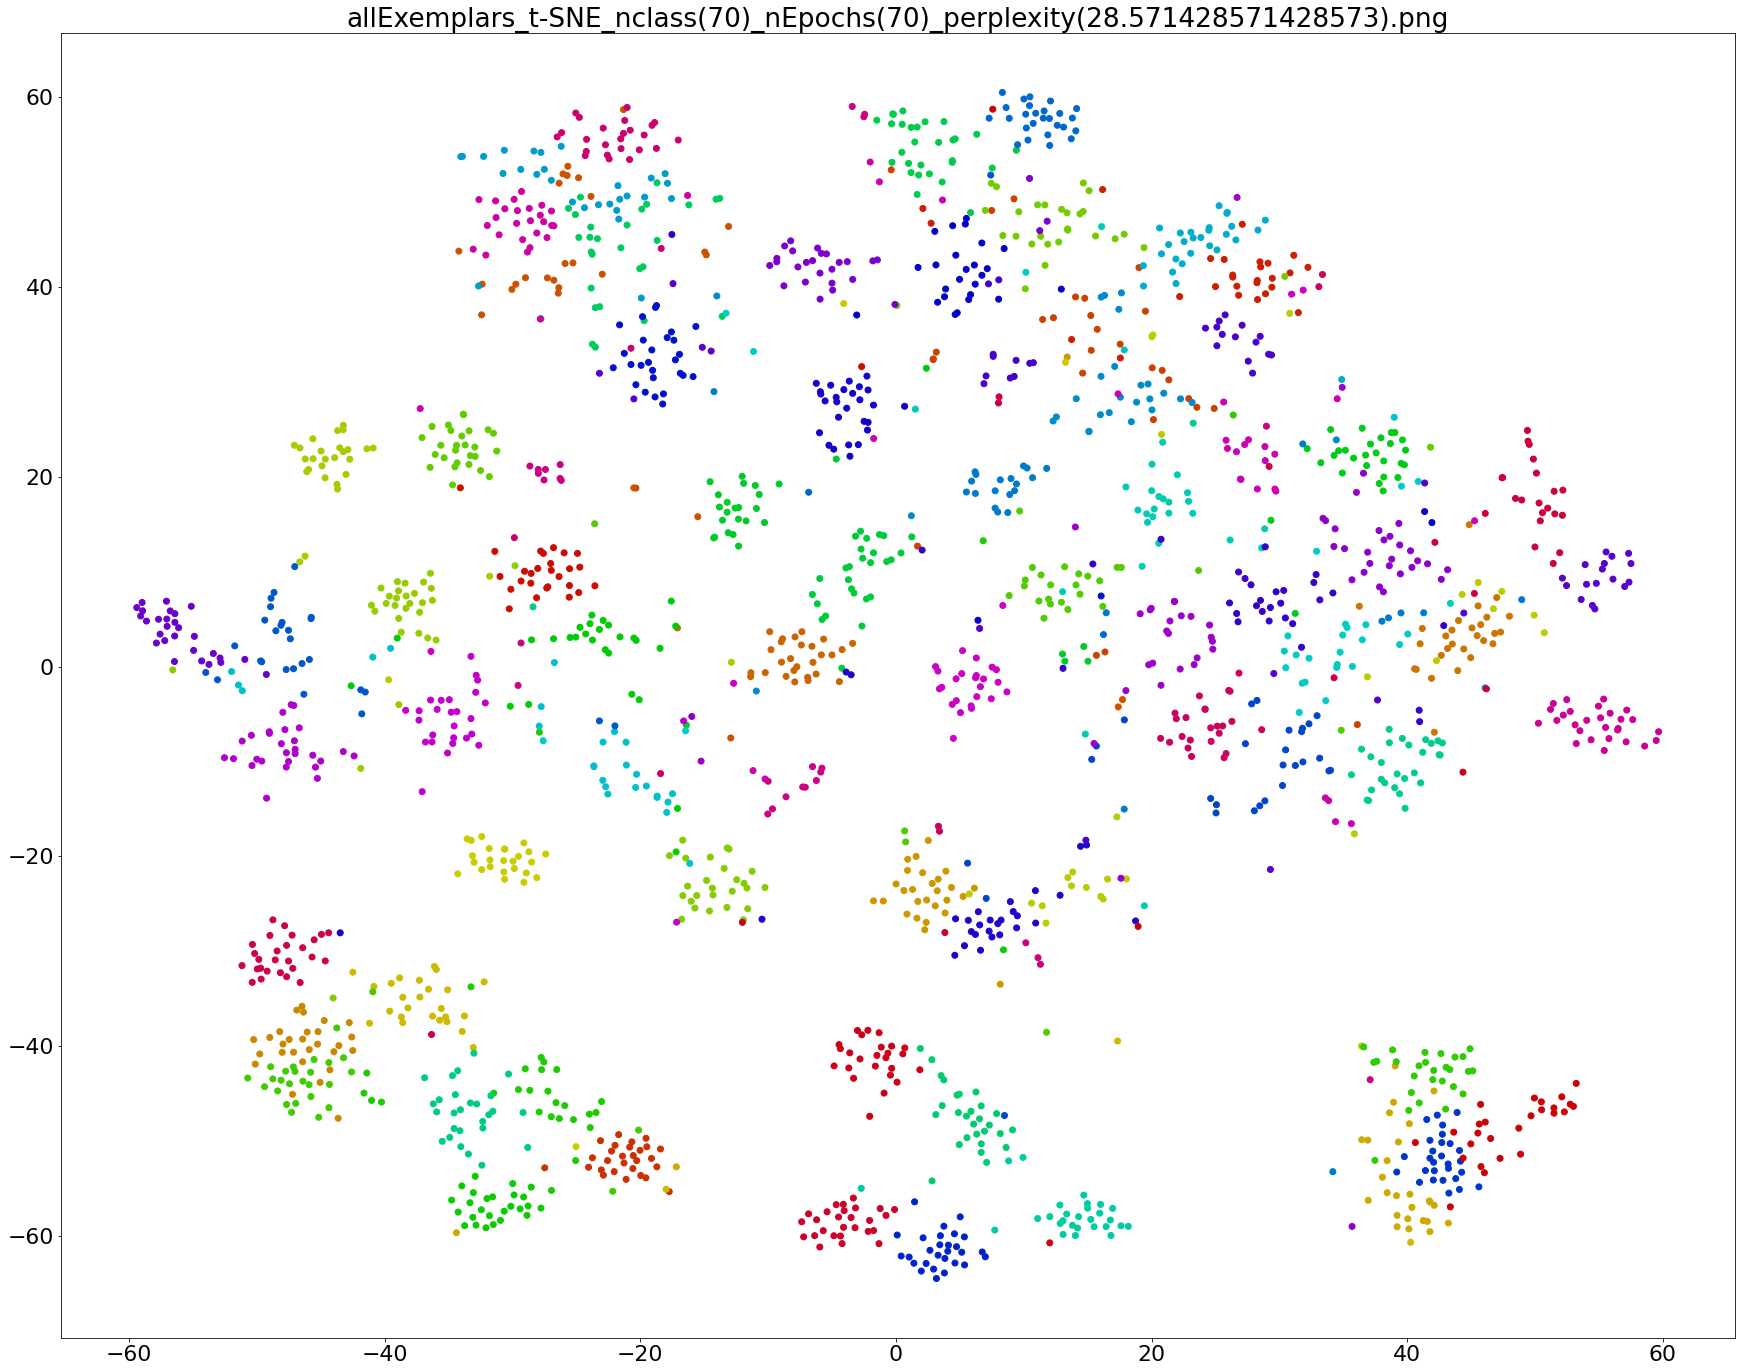

dataX shape and labelsY size...
(280, 64)
torch.Size([280])
Creating tSNE Model...
(280, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


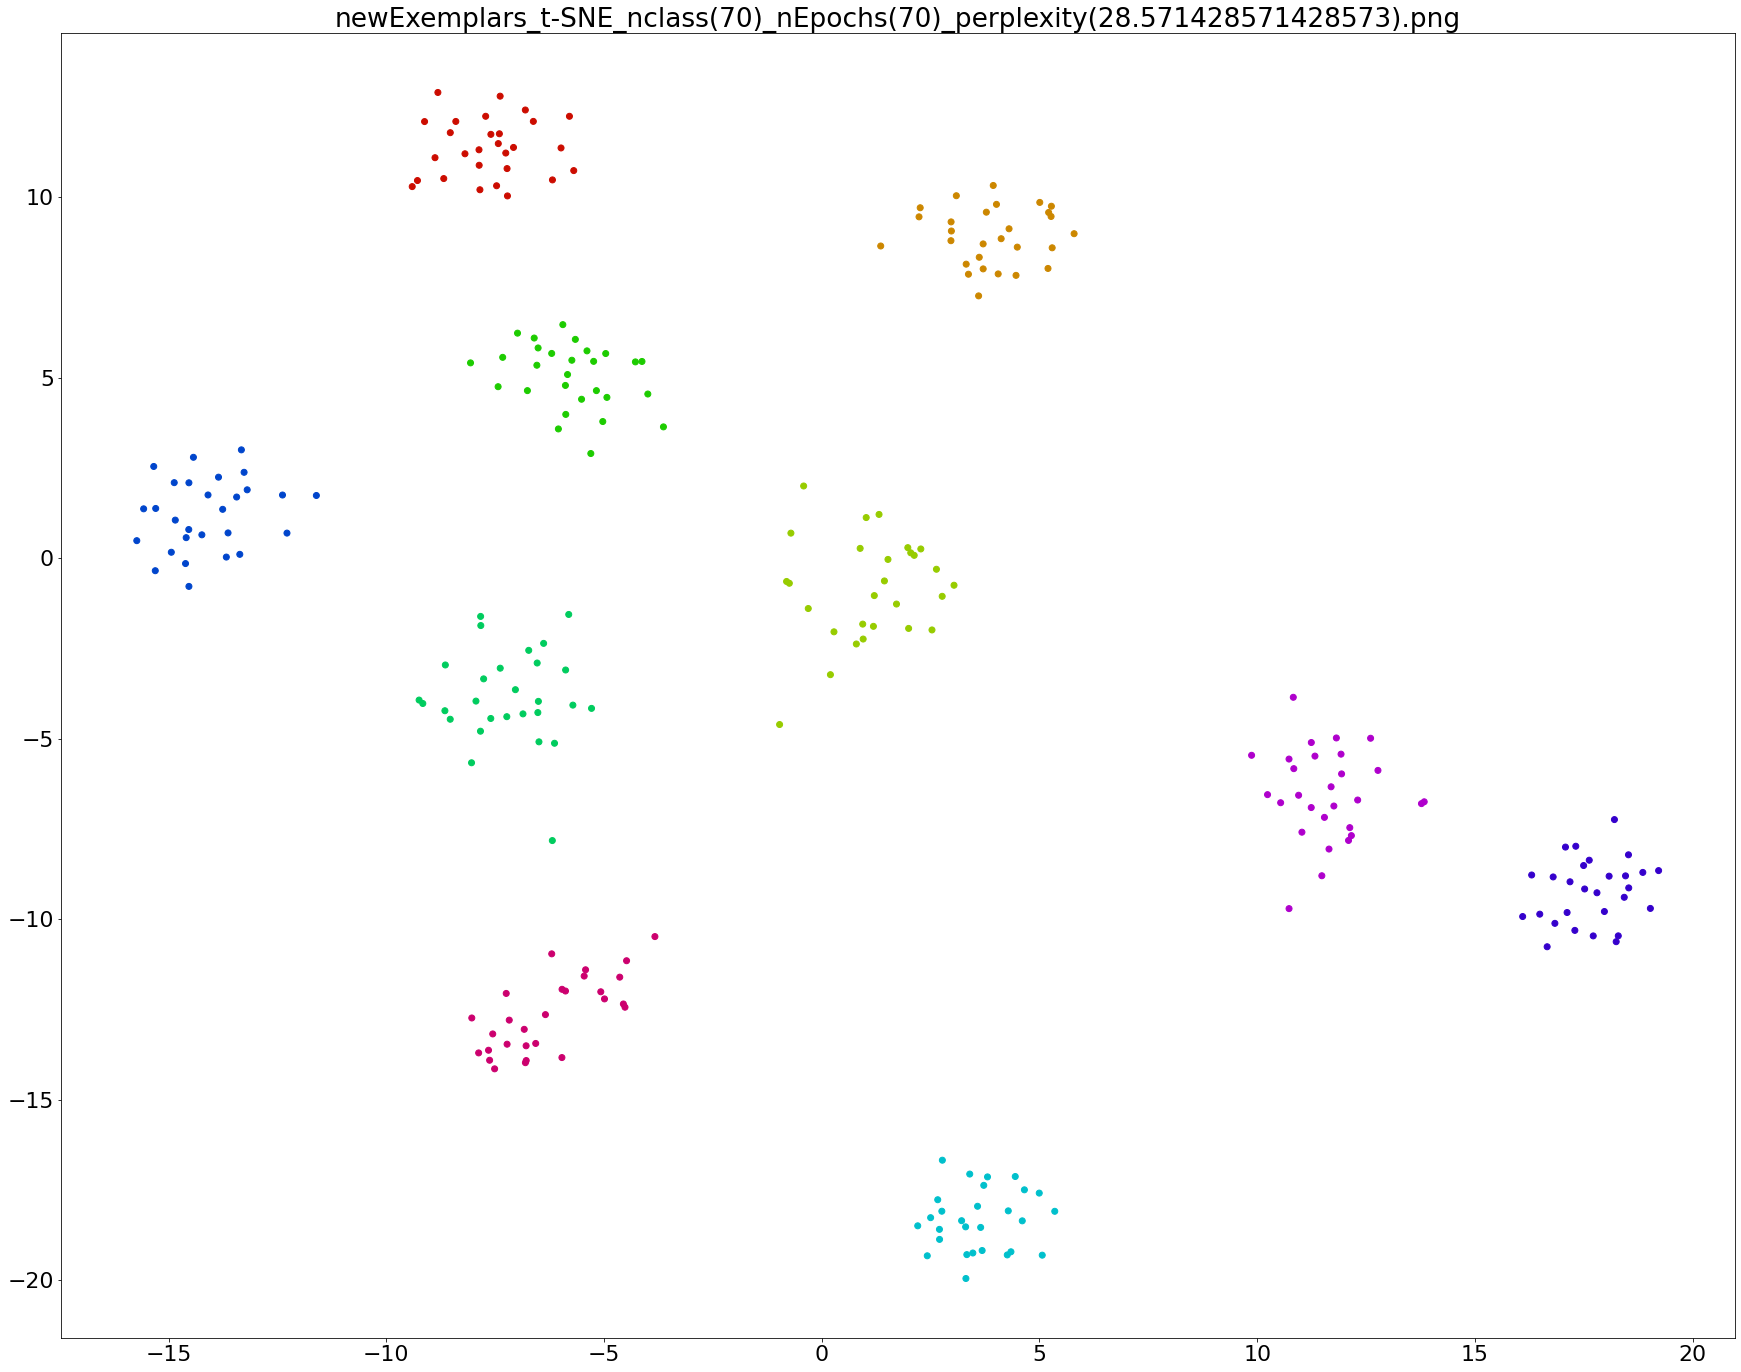

Loading training examples for classes [18, 64, 97, 34, 56, 89, 85, 30, 9, 25]
Batch size: 5000
10 new classes
5000
6960
TRAIN
Epoch [5/70], Average_Loss: 0.0943
Epoch [10/70], Average_Loss: 0.0919
Epoch [15/70], Average_Loss: 0.0914
Epoch [20/70], Average_Loss: 0.0901
Epoch [25/70], Average_Loss: 0.0898
Epoch [30/70], Average_Loss: 0.0891
Epoch [35/70], Average_Loss: 0.0890
Epoch [40/70], Average_Loss: 0.0886
Epoch [45/70], Average_Loss: 0.0883
Epoch [50/70], Average_Loss: 0.0855
Epoch [55/70], Average_Loss: 0.0829
Epoch [60/70], Average_Loss: 0.0825
Epoch [65/70], Average_Loss: 0.0820
Epoch [70/70], Average_Loss: 0.0821
Constructing exemplar set for class-18...
Done exemplars
Constructing exemplar set for class-64...
Done exemplars
Constructing exemplar set for class-97...
Done exemplars
Constructing exemplar set for class-34...
Done exemplars
Constructing exemplar set for class-56...
Done exemplars
Constructing exemplar set for class-89...
Done exemplars
Constructing exemplar set for

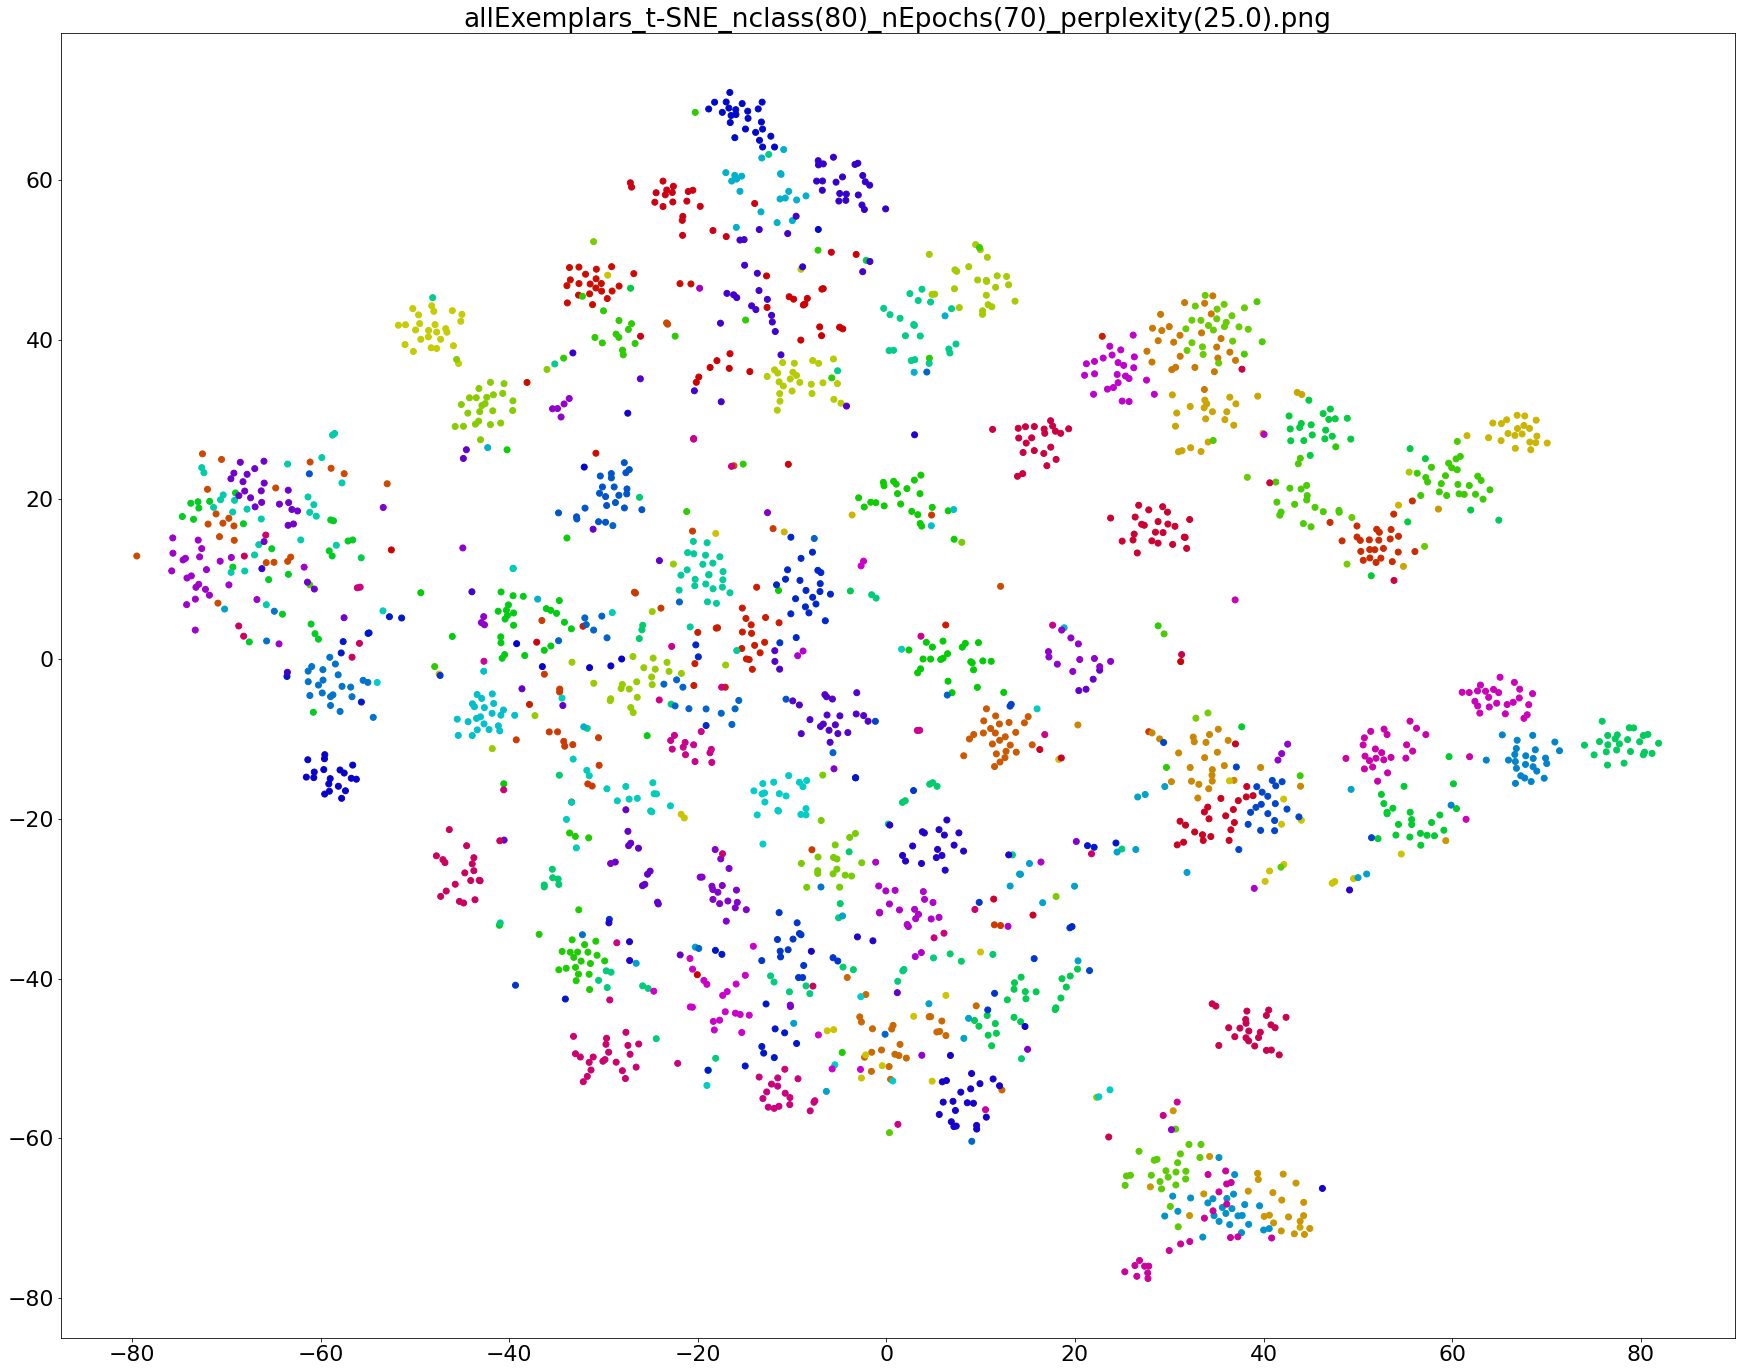

dataX shape and labelsY size...
(250, 64)
torch.Size([250])
Creating tSNE Model...
(250, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


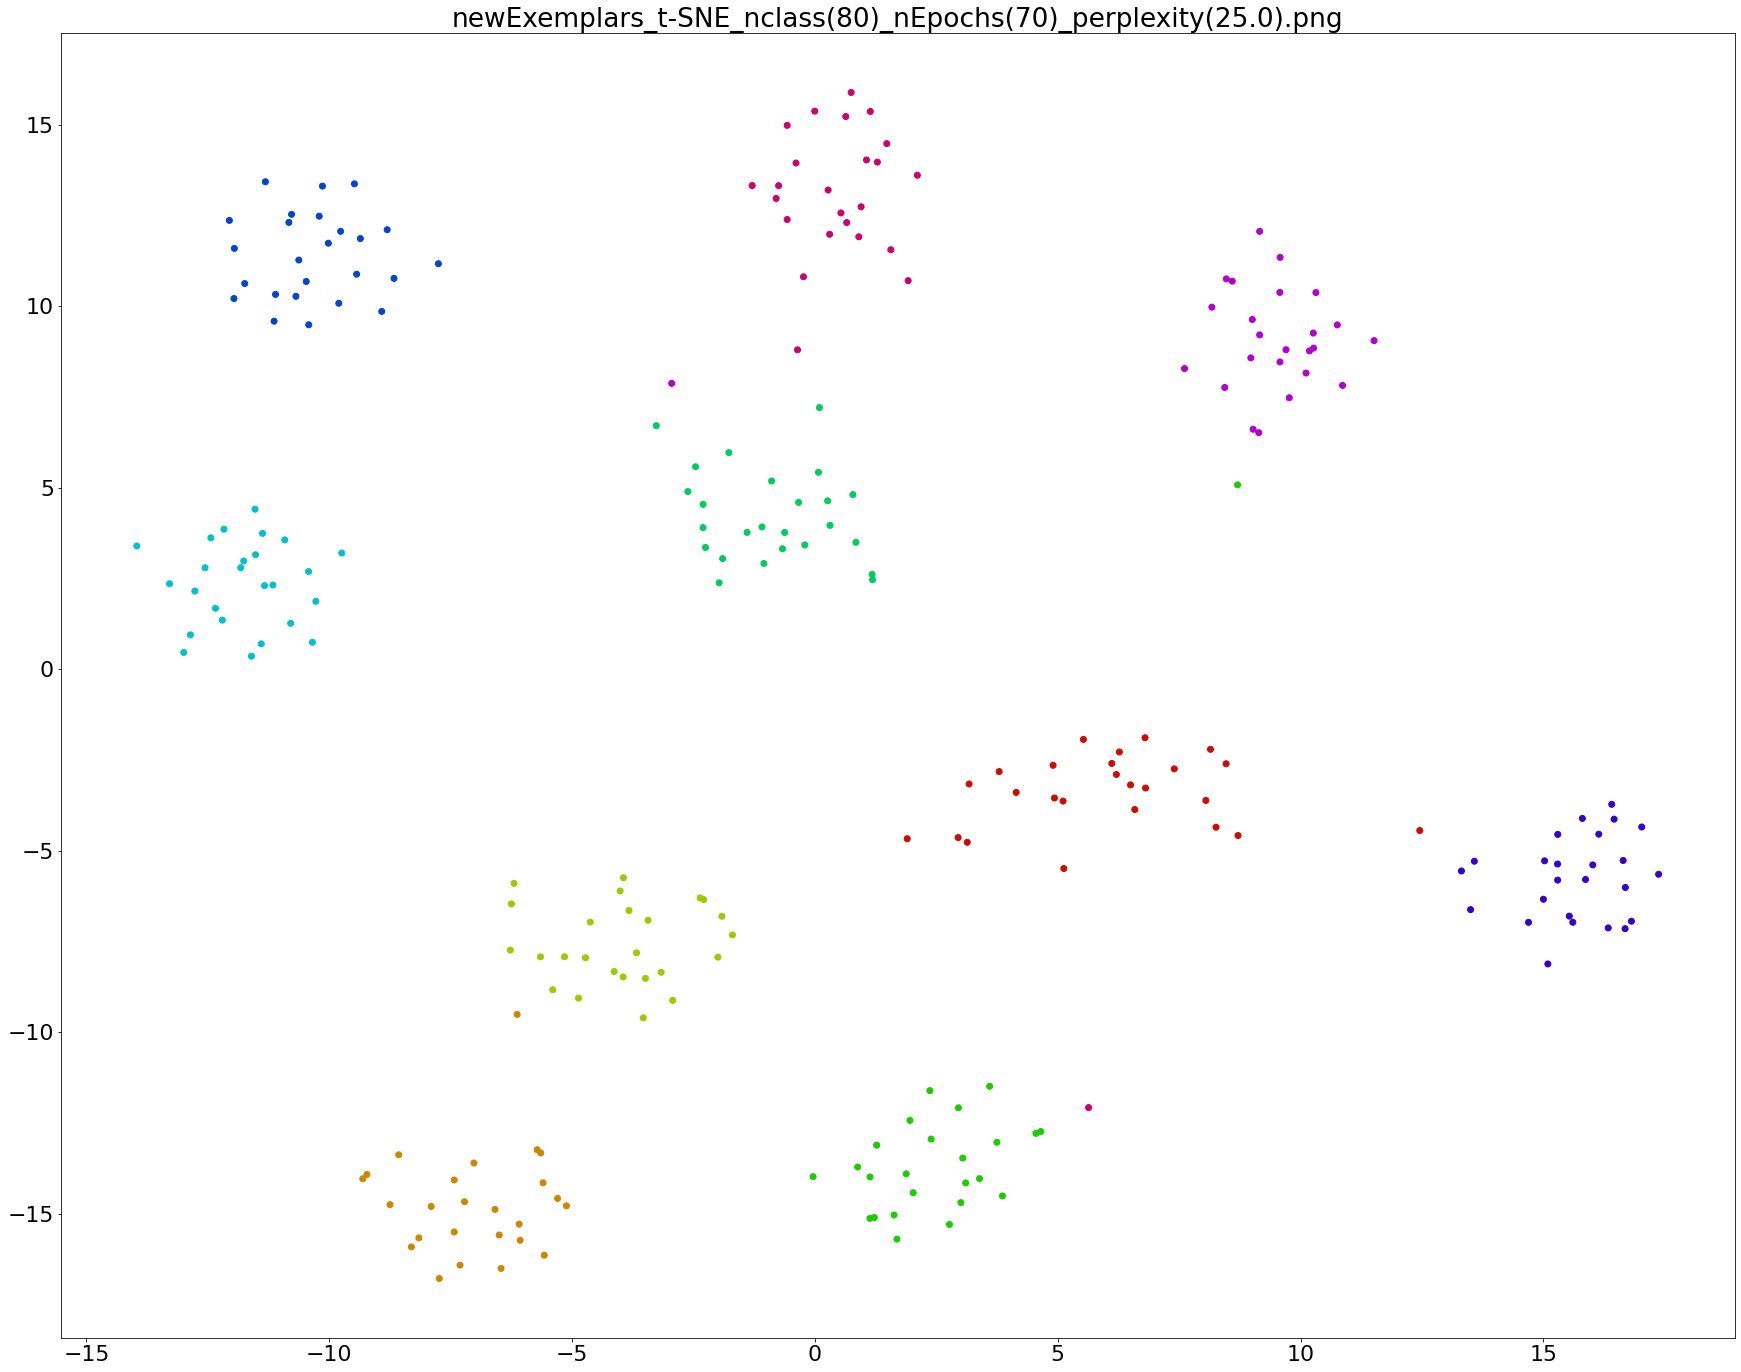

Loading training examples for classes [70, 48, 57, 84, 92, 53, 67, 65, 10, 31]
Batch size: 5000
10 new classes
5000
7000
TRAIN
Epoch [5/70], Average_Loss: 0.0920
Epoch [10/70], Average_Loss: 0.0902
Epoch [15/70], Average_Loss: 0.0888
Epoch [20/70], Average_Loss: 0.0887
Epoch [25/70], Average_Loss: 0.0880
Epoch [30/70], Average_Loss: 0.0870
Epoch [35/70], Average_Loss: 0.0867
Epoch [40/70], Average_Loss: 0.0868
Epoch [45/70], Average_Loss: 0.0871
Epoch [50/70], Average_Loss: 0.0839
Epoch [55/70], Average_Loss: 0.0817
Epoch [60/70], Average_Loss: 0.0811
Epoch [65/70], Average_Loss: 0.0811
Epoch [70/70], Average_Loss: 0.0807
Constructing exemplar set for class-70...
Done exemplars
Constructing exemplar set for class-48...
Done exemplars
Constructing exemplar set for class-57...
Done exemplars
Constructing exemplar set for class-84...
Done exemplars
Constructing exemplar set for class-92...
Done exemplars
Constructing exemplar set for class-53...
Done exemplars
Constructing exemplar set fo

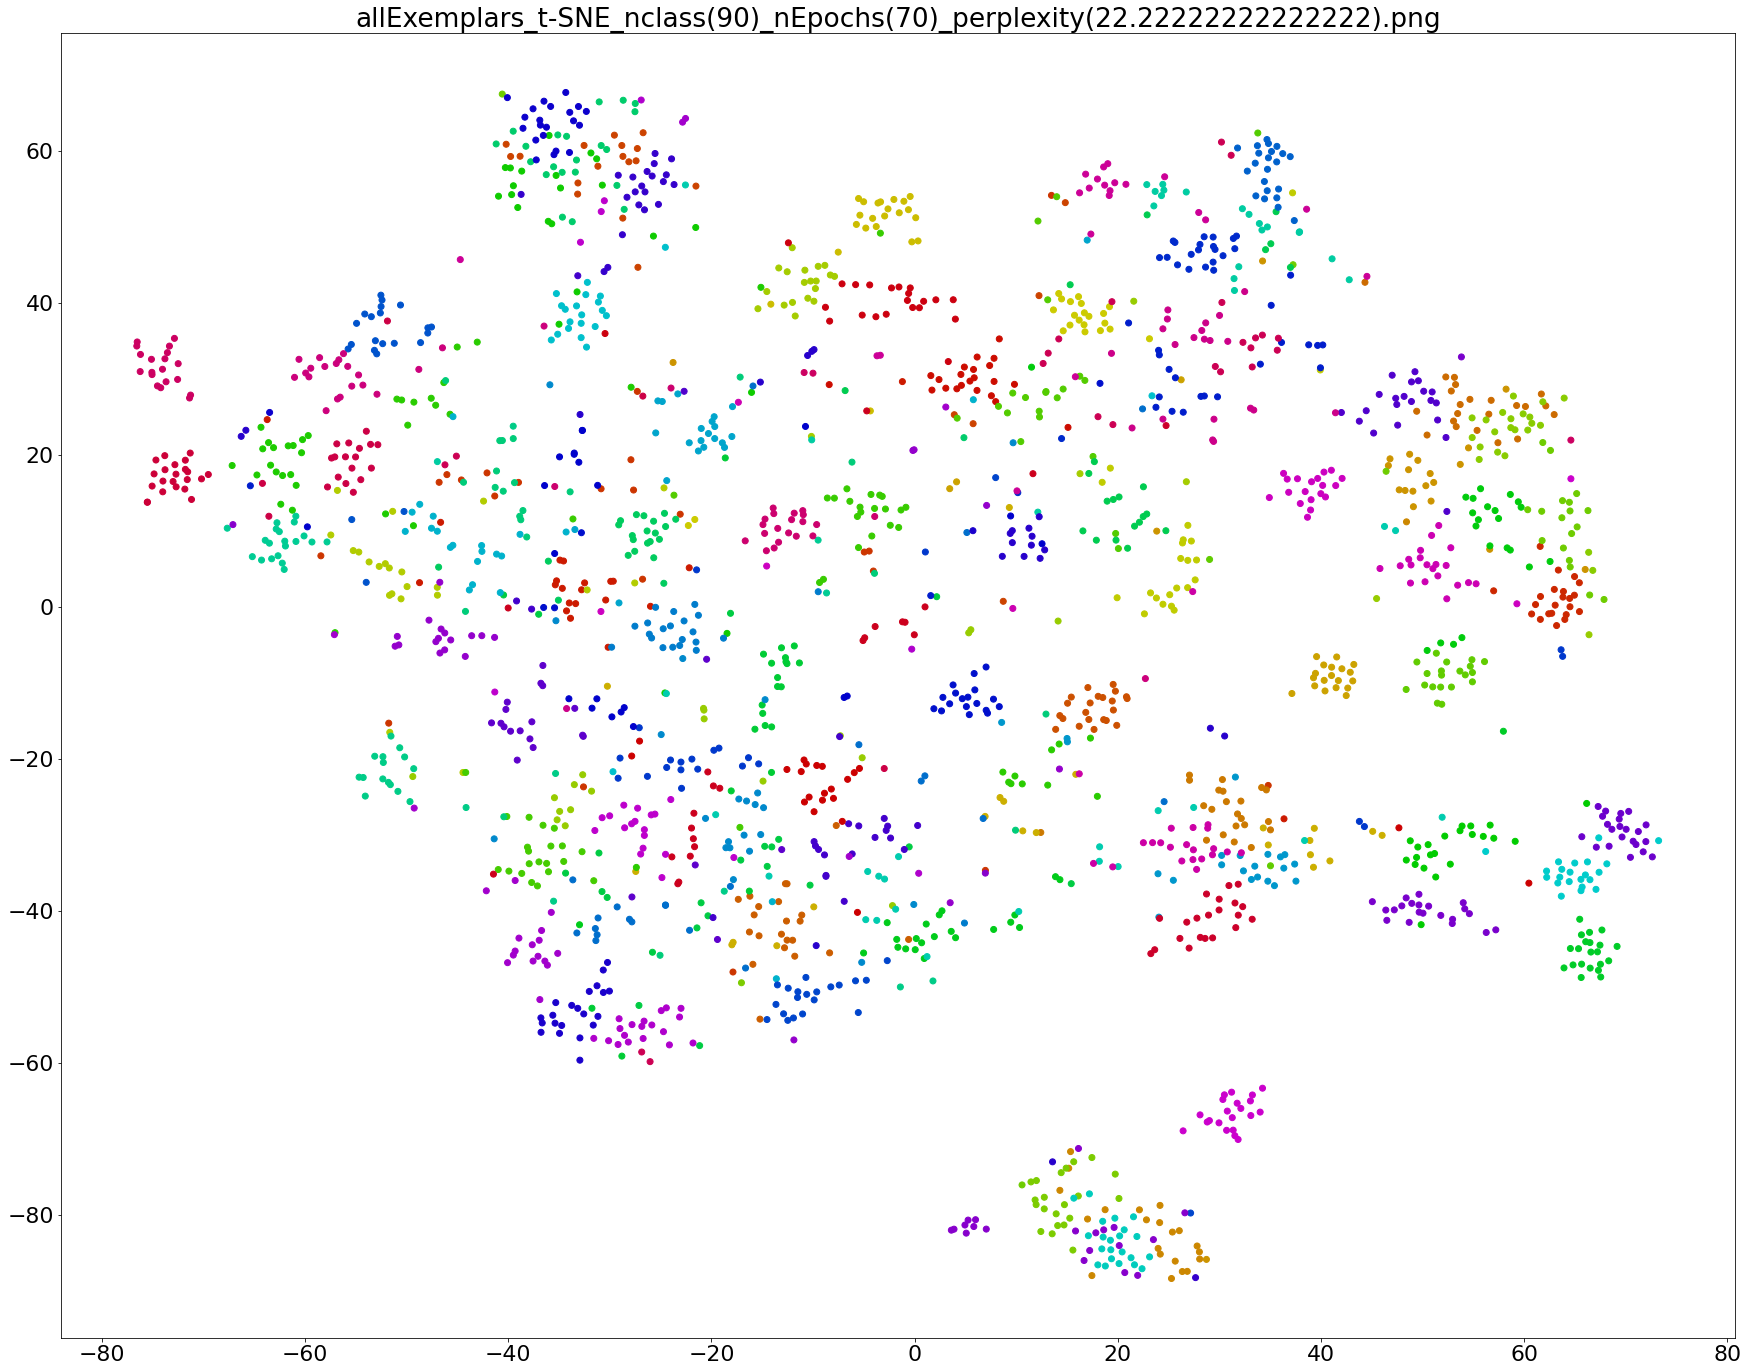

dataX shape and labelsY size...
(220, 64)
torch.Size([220])
Creating tSNE Model...
(220, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


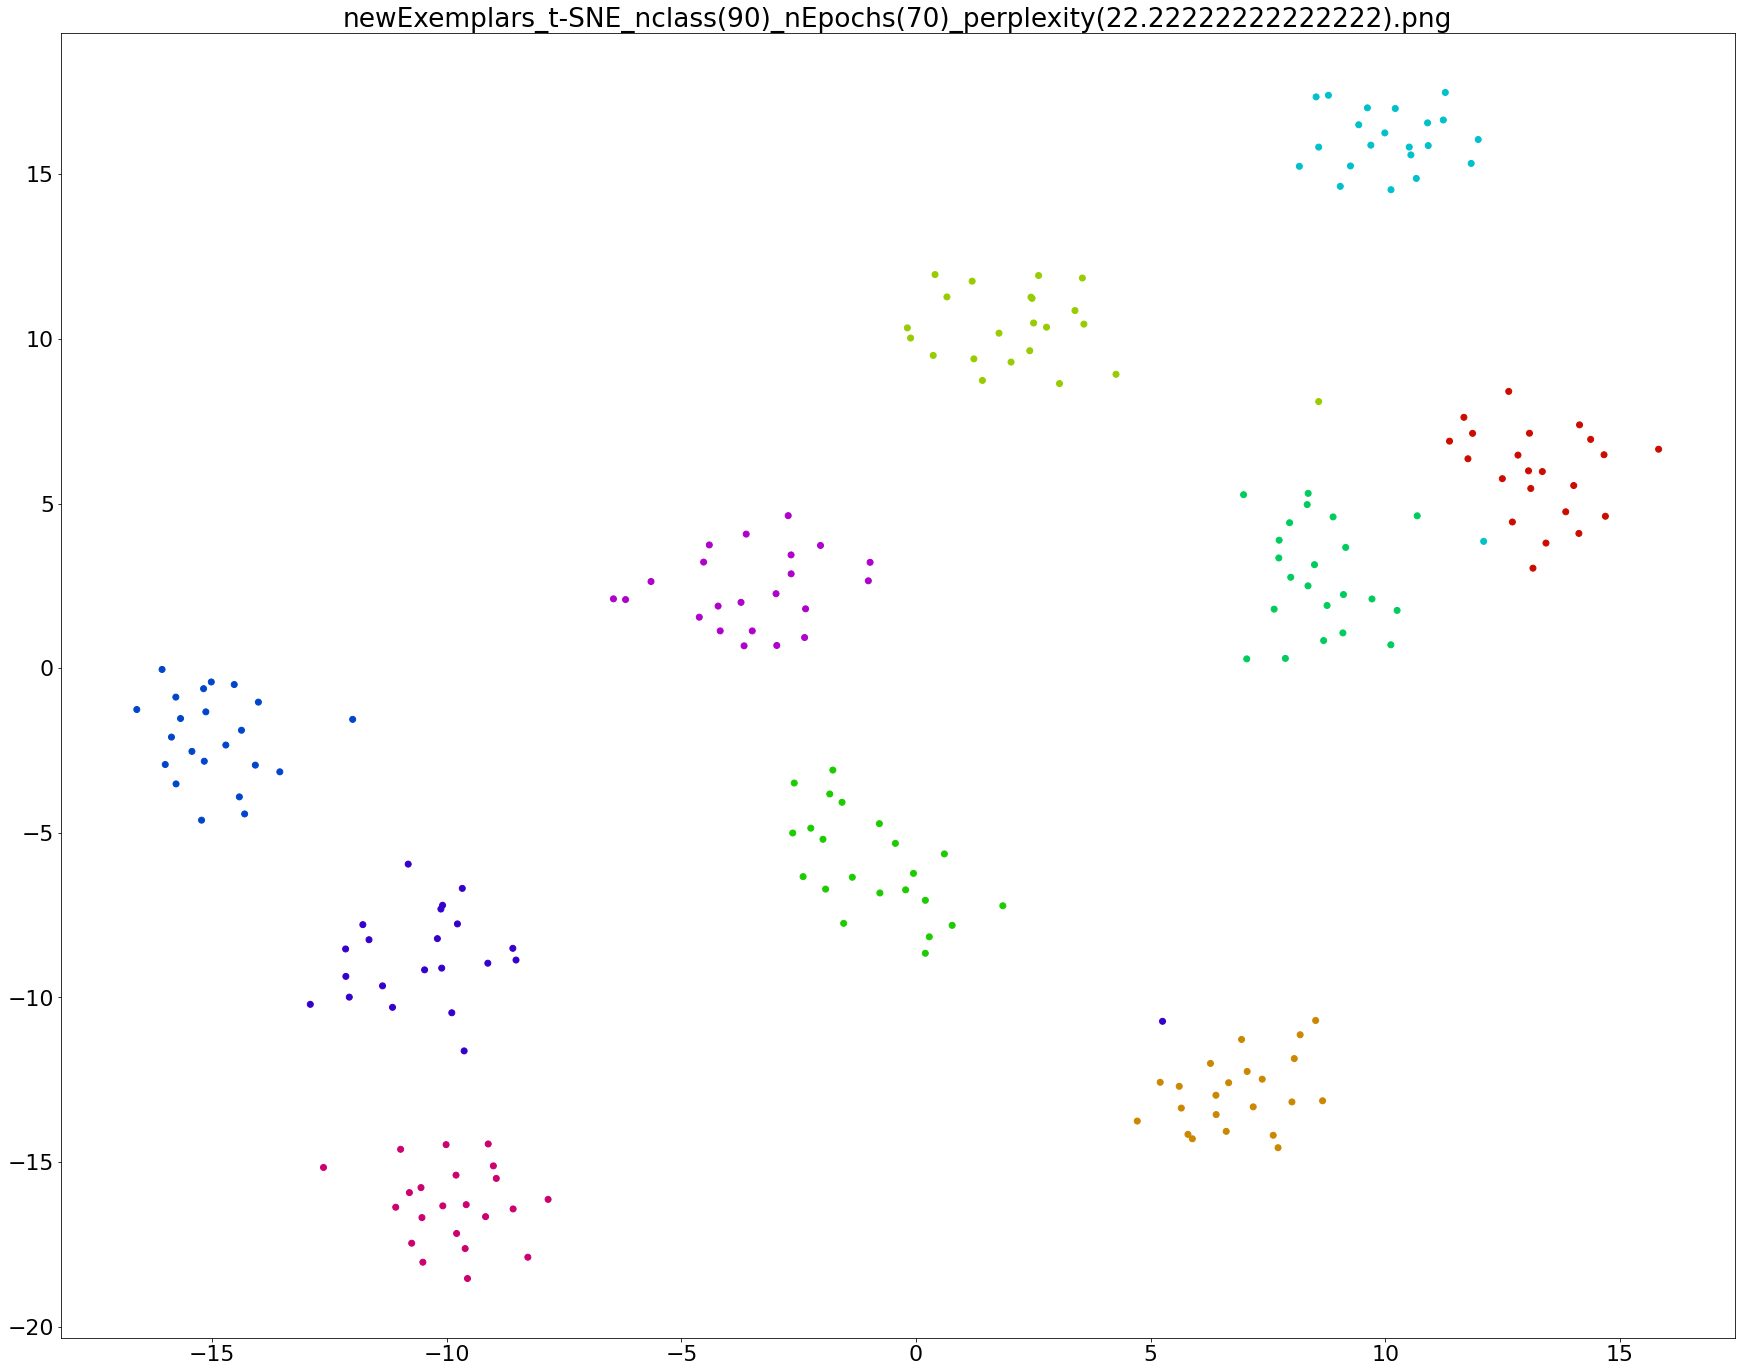

Loading training examples for classes [88, 33, 4, 21, 74, 32, 62, 0, 55, 44]
Batch size: 5000
10 new classes
5000
6980
TRAIN
Epoch [5/70], Average_Loss: 0.0947
Epoch [10/70], Average_Loss: 0.0935
Epoch [15/70], Average_Loss: 0.0927
Epoch [20/70], Average_Loss: 0.0923
Epoch [25/70], Average_Loss: 0.0914
Epoch [30/70], Average_Loss: 0.0910
Epoch [35/70], Average_Loss: 0.0908
Epoch [40/70], Average_Loss: 0.0899
Epoch [45/70], Average_Loss: 0.0902
Epoch [50/70], Average_Loss: 0.0871
Epoch [55/70], Average_Loss: 0.0853
Epoch [60/70], Average_Loss: 0.0849
Epoch [65/70], Average_Loss: 0.0845
Epoch [70/70], Average_Loss: 0.0847
Constructing exemplar set for class-88...
Done exemplars
Constructing exemplar set for class-33...
Done exemplars
Constructing exemplar set for class-4...
Done exemplars
Constructing exemplar set for class-21...
Done exemplars
Constructing exemplar set for class-74...
Done exemplars
Constructing exemplar set for class-32...
Done exemplars
Constructing exemplar set for c

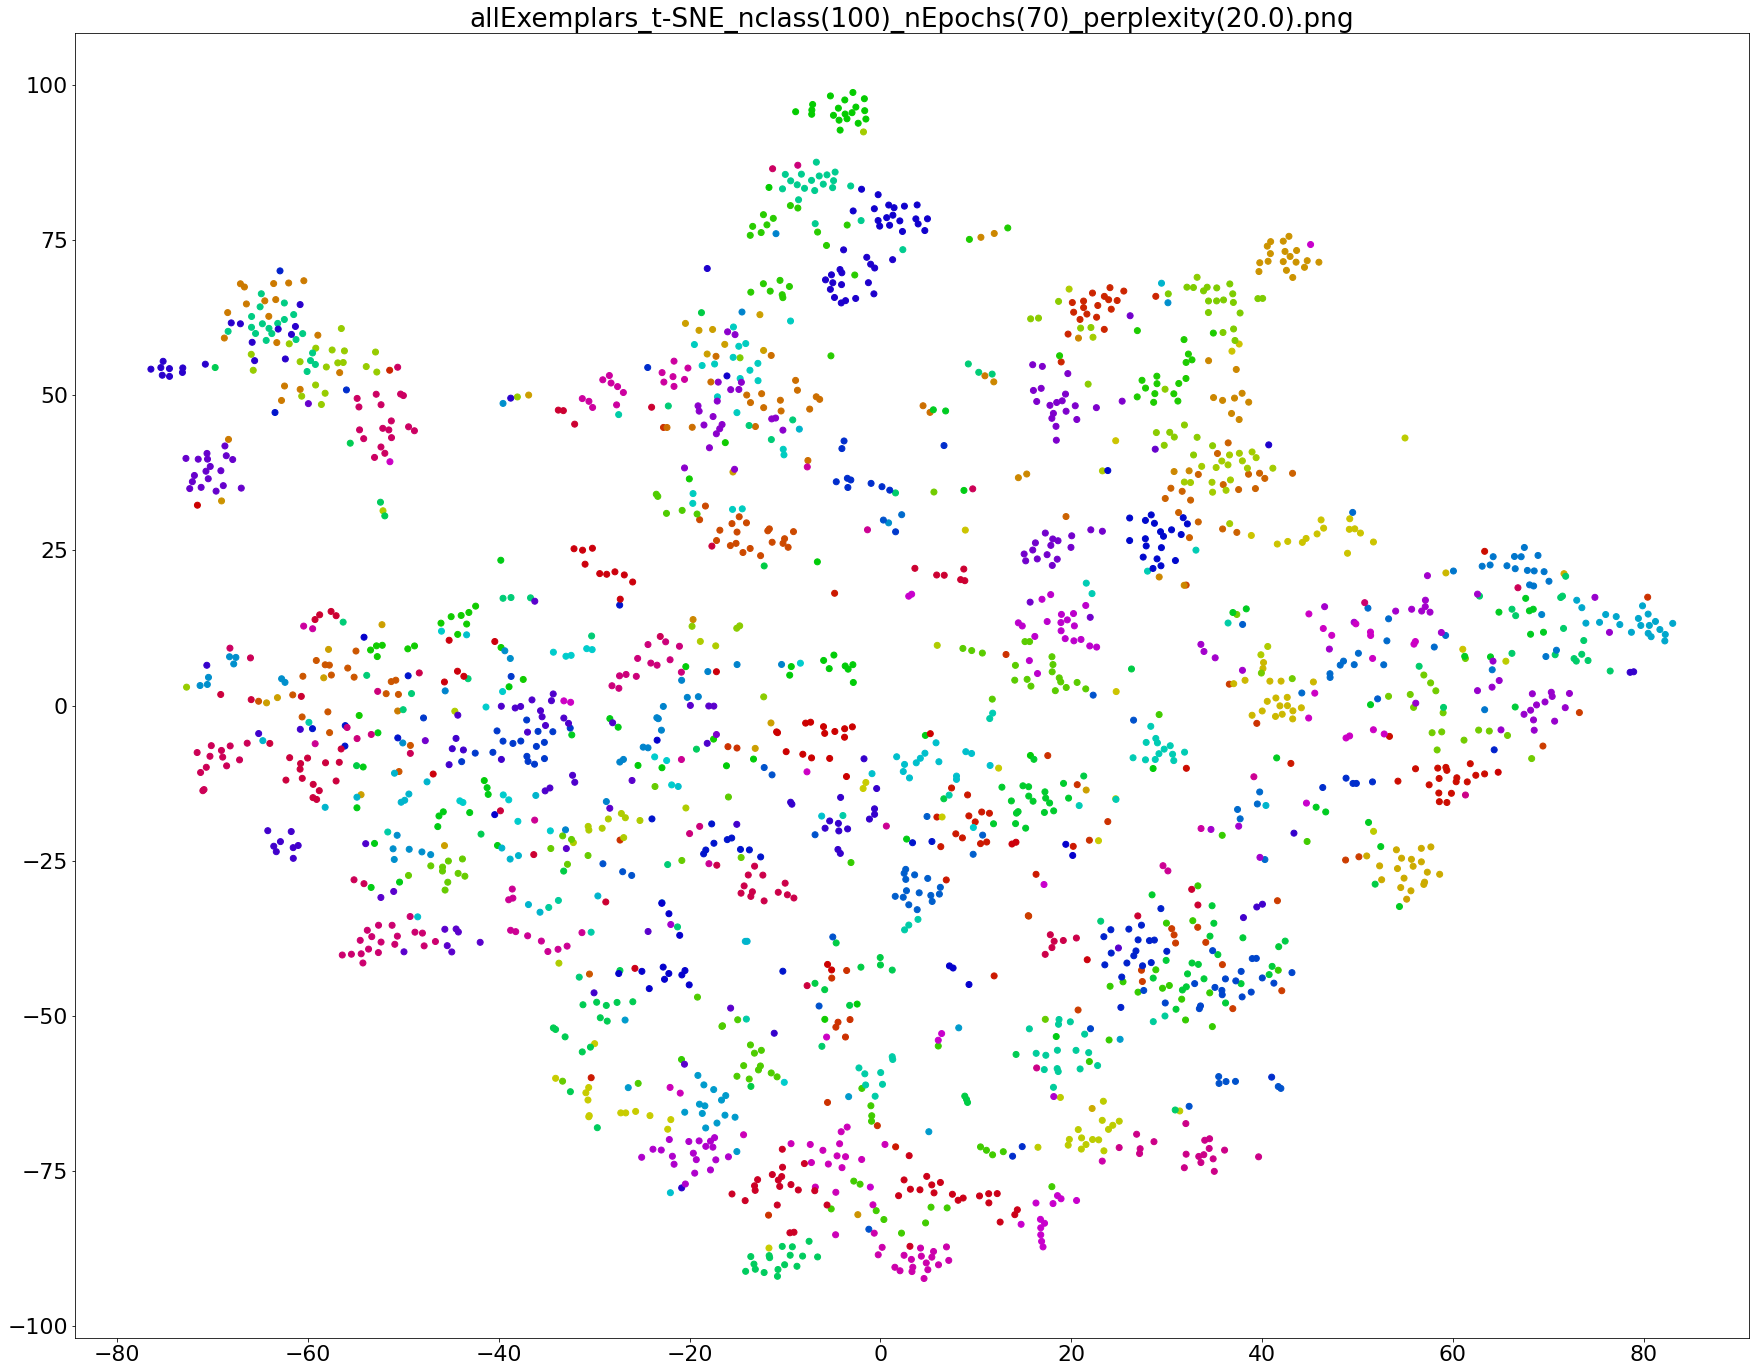

dataX shape and labelsY size...
(200, 64)
torch.Size([200])
Creating tSNE Model...
(200, 2)
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root/tSNE-Studies/incremental/perplexityM
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root


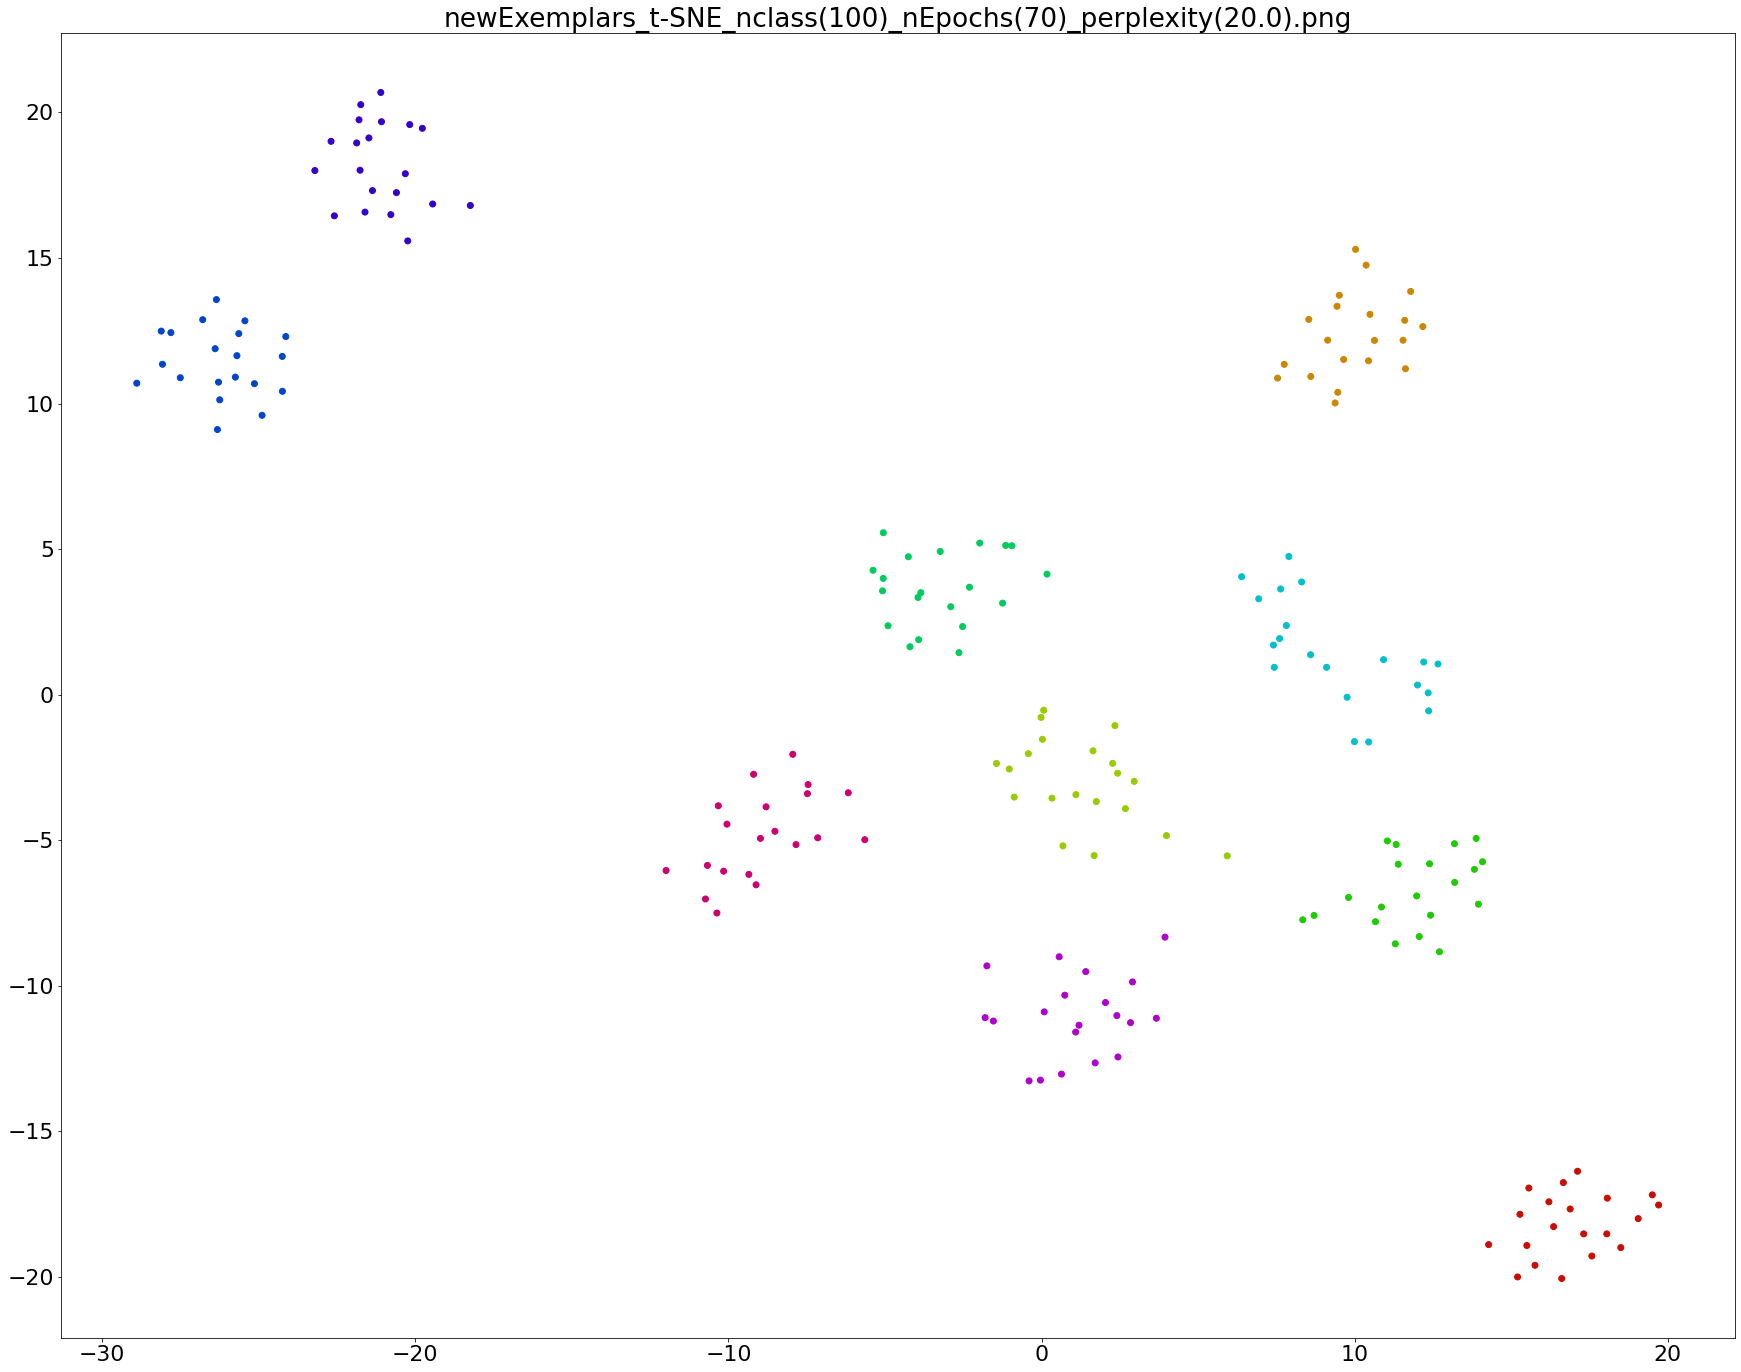

[85.82589285714286, 74.63541666666667, 70.65217391304348, 64.23891129032258, 60.31650641025641, 57.40489130434783, 53.54456018518518, 50.46622983870968, 47.734375, 44.86177884615385]


In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random



torch.cuda.current_device()
torch.cuda._initialized = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


# Hyper Parameters
total_classes = 100
num_classes = 10


def accuracy_on(dl, model, cif):
  total = 0
  correct = 0
  
  # it iterates over a data loader so it returns batches of data
  for ind, images, labels in dl: 
    labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
    images = Variable(images).cuda()
    pred = model.classify(images, cif)#.cuda()
    total += len(labels)

    n = 0
    for p, l in zip(pred, labels):
      if p == l:
        n += 1
    correct += n

  return correct / total

# Initialize CNN
K = 2000  # total number of exemplars
icarl = iCaRLNet(64, 100, num_epochs=70)
icarl = icarl.to(DEVICE)
BATCH_SIZE = 128
acc_vect = []

randomseed = 981
cifarTrain = cifar_100(num_classes, 'train', randomseed)
cifarTest = cifar_100(num_classes, 'test', randomseed)
randomlist = cifarTrain.get_classes_list()
diz = cifarTrain.get_dictionary()

print(f"randomlist = {randomlist}")

for s in range(10):
    # Load Datasets
    print("Loading training examples for classes", randomlist[s*num_classes:s*num_classes + num_classes])
    batchindexes = cifarTrain.getClassIndexes(randomlist[s*num_classes:s*num_classes + num_classes])
    batch = Subset(cifarTrain, batchindexes)

    print("Batch size: {}".format(len(batch)))
    testindexes = cifarTest.getClassIndexes(randomlist[0:s*num_classes + num_classes])
    test_set = Subset(cifarTest, testindexes)


    train_loader = torch.utils.data.DataLoader(batch, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=4, drop_last=True)

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False, num_workers=4, drop_last=True)


    # Update representation via BackProp
    icarl.train()
    icarl.update_representation(cifarTrain, batchindexes, diz)
    icarl.eval()
    m = K / icarl.n_classes

    # Reduce exemplar sets for known classes
    icarl.reduce_exemplar_sets(m)

    # Construct exemplar sets for new classes
    for y in randomlist[s*num_classes:s*num_classes + num_classes]:
        print("Constructing exemplar set for class-%d..." % (y))
        imagesInd = cifarTrain.getClassIndexes([y])
        images = Subset(cifarTrain, imagesInd)
        # print(imagesInd)
        icarl.construct_exemplar_set(images, m)
        print("Done exemplars")

    icarl.n_known = icarl.n_classes
    print("iCaRL classes: %d" % icarl.n_known)

    total = 0.0
    correct = 0.0

    print(len(train_loader))
    for indices, images, labels in train_loader:
        labels = [torch.tensor(diz[c.item()]) for c in labels]
        labels = torch.tensor(labels)
        images = Variable(images).cuda()
        preds = icarl.classify(images, cifarTrain)
        total = total + len(labels)
        correct += (preds.data.cpu() == labels).sum()

    print('Train Accuracy: %d %%' % (100 * correct / total))
    print(f'Train Accuracy: {accuracy_on(train_loader, icarl, cifarTrain)}')
    total = 0.0
    correct = 0.0

    for indices, images, labels in test_loader:
        labels = [torch.tensor(diz[c.item()]) for c in labels]
        labels = torch.tensor(labels)
        images = Variable(images).cuda()
        preds = icarl.classify(images, cifarTrain)
        total = total + len(labels)
        correct += (preds.data.cpu() == labels).sum()

    print('Test Accuracy: %d %%' % (100 * correct / total))
    print(f'Train Accuracy: {accuracy_on(test_loader, icarl, cifarTrain)}')
    acc_vect.append(100 * correct.item() / total)

    icarl.exemplarsTSNE(cifarTrain, randomlist, m, inc=False)
    icarl.exemplarsTSNE(cifarTrain, randomlist, m, inc=True)
    

print(acc_vect)
